# Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
import itertools
import math
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt


from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.9) # Memory usage limit for MacOS
    torch.mps.empty_cache() 
else:
    device = torch.device("cpu")


from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None

device

device(type='mps')

#### For cleaning memory

In [2]:
import gc
import weakref

for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps: # or obj.is_cuda
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache() # or torch.cuda.empty_cache()

# Data

In [3]:
class RecommendationDataset(Dataset):
    def __init__(self, user_recommendations, user_to_true_items, k):
        self.recommendations = [torch.LongTensor(recs[:k]) for recs in user_recommendations.values()]
        self.true_items = [torch.LongTensor(list(user_to_true_items.get(u, []))) for u in user_recommendations.keys()]
        self.true_len = [len(t) for t in self.true_items] 
        self.k = k

    def __len__(self):
        return len(self.true_items)

    def __getitem__(self, idx):
        return {
            'recs': self.recommendations[idx], 
            'true': self.true_items[idx],
            'true_len': self.true_len[idx]
        }
    

def collate_fn(batch, device='mps'):
    """
    Собираем батч целиком в тензоры, чтобы все метрики считались
    без питоновских циклов (vectorized GPU).
    Возвращаем:
        recs      – LongTensor [B, k]
        true      – LongTensor [B, L_max] (padding = -1)
        true_len  – LongTensor [B]        (длина истинного списка)
    """
    recs = torch.stack([item['recs'] for item in batch])          # [B, k]
    true_len = torch.tensor([item['true_len'] for item in batch], dtype=torch.long)
    L_max = int(true_len.max()) if true_len.numel() else 0
    true_pad = torch.full((len(batch), L_max), -1, dtype=torch.long)  # -1: sentinel
    
    for i, item in enumerate(batch):
        if true_len[i]:
            true_pad[i, :true_len[i]] = item['true']

    return {
        'recs': recs.to(device),
        'true': true_pad.to(device),
        'true_len': true_len.to(device)
    }

## Products Data

In [4]:
file_path = Path().resolve() # Path(__file__).resolve()
project_dir = file_path.parent
raw_data_path = project_dir / 'data' / 'raw'
products_data_dir = project_dir / 'data' / 'processed' / 'products_data'
interim_data_dir = project_dir / 'data' / 'interim'
models_outputs_dir = project_dir / 'data' / 'processed' / 'models_outputs'
models_dir = project_dir / 'models'
processed_images_dir = products_data_dir / 'processed_images_224x224'
products_data_file = products_data_dir / 'products_data.parquet'

raw_data_path.mkdir(parents=True, exist_ok=True)
products_data_dir.mkdir(parents=True, exist_ok=True)
interim_data_dir.mkdir(parents=True, exist_ok=True)
models_outputs_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)
processed_images_dir.mkdir(parents=True, exist_ok=True)


In [5]:

df_products = pd.read_parquet(products_data_file)
df_products.tail(2)

,articul_encrypred,color_base,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,slug,photo_analytics,sales_total,image_path,CLS_google_vit_huge_patch14_224_in21k,mean_patch_google_vit_huge_patch14_224_in21k,pooled_google_vit_huge_patch14_224_in21k,pooled_microsoft_resnet50,CLS_openai_clip_vit_large_patch14,mean_patch_openai_clip_vit_large_patch14,pooled_openai_clip_vit_large_patch14,description,embedding_e5_large_v2,embedding_bge_large_en_v15,embedding_nomic_embed_text_v15
306670,wqsvuwy,Разноцветный,Lancel,Товары для женщин,Аксессуары,Платки,Платок шелковый,Шелковый платок,13567982,2020-06-25,6027468-shelkovyi-platok-lancel-raznotcvetnyi-...,https://st-cdn.tsum.com/int/height/1526/i/f5/9...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[0.14456921815872192, -0.06249238923192024, -0...","[0.013126503676176071, -0.0019127298146486282,...","[0.22613008320331573, 0.1457078456878662, -0.1...","[0.030423777177929878, 0.0, 0.0, 0.08489743620...","[0.15574012696743011, -0.3459433317184448, 0.6...","[0.6875616312026978, 0.6793960332870483, 0.354...","[0.42158013582229614, 0.2945811450481415, 0.35...",This Lancel silk scarf features shades of blue...,"[0.02612929418683052, -0.05050811171531677, 0....","[-0.020242616534233093, -0.01976708509027958, ...","[0.01306484080851078, 0.022184912115335464, -0..."
306671,ttquswt,Чёрный,Giorgio Armani,Товары для женщин,Бижутерия,Брошь,Брошь,Брошь,11201309,2016-07-26,5504265-brosh-giorgio-armani-chernyi,https://st-cdn.tsum.com/int/height/1526//i/76/...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[-0.12436471879482269, -0.030923746526241302, ...","[-0.01337357982993126, -0.0029991380870342255,...","[-0.09756504744291306, -0.15952929854393005, 0...","[0.03119073063135147, 0.0002419875527266413, 0...","[0.5343070030212402, 0.26047518849372864, 0.37...","[0.7018769979476929, 0.5926704406738281, 0.369...","[0.2984030842781067, 0.4144335687160492, -0.12...",This item is a black brooch from Giorgio Arman...,"[0.013706686906516552, -0.061785973608493805, ...","[-0.029468011111021042, 0.002113671973347664, ...","[0.03772303834557533, 0.08191631734371185, -0...."


There are some broken URLs — we remove these items from our dataset.

![alt text](../junk/broken_urls.png)

In [7]:
print(f'Total number of rows initially: {df_products.shape[0]}')
print(f'Number of rows with at least one missing value: {df_products[df_products.isna().any(axis=1)].shape[0]}')

df_products.dropna(inplace=True)
print(f'Number of rows after cleaning: {df_products.shape[0]}')

# df_products.to_parquet(interim_data_dir / 'df_products.parquet', index=False)

Total number of rows initially: 306672
Number of rows with at least one missing value: 8
Number of rows after cleaning: 306664


## Sales Data

In [8]:
# df_parsed = pd.read_csv(raw_data_path / 'all.csv', sep=';')
# df_sales = pd.read_csv(raw_data_path / 'all_orders_encrypted_2020_small_30012024_3.csv', sep=',')
# df_assortment = pd.read_csv(raw_data_path / 'tsum_assortment_31012025.csv', sep=',')
df_sales = pd.read_csv(raw_data_path / 'full_orders_v6.csv', sep=None, engine='python')

# display(df_parsed.tail(2), df_sales.tail(2), df_assortment.tail(2), df_sales.tail(2))
df_sales.tail(2)

,anon_id_encrypred,articul_encrypred,color_base,sizeid,size_title,order_date,store,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,base_price,net_price,sale_percentage,slug,photo_analytics
3485910,wyyypqqtpqqyuqqx,vqquspp,Чёрный,48,48,2021-02-18,T,Dolce&Gabbana,Товары для мужчин,Одежда,Одежда верхняя,Жилеты,Утепленный жилет,13627178,2020-10-21,124500.0,124500.0,0.000000,7004211-uteplennyi-zhilet-dolce-gabbana-chernyi,https://st-cdn.tsum.com/int/height/1526/i/ad/b...
3485911,wyyyrqqtqqrruyyp,vqsywtp,Серый,40,42,2021-02-18,T,The Attico,Товары для женщин,Одежда,Одежда джинсовая,Куртка джинсовая,Джинсовая куртка,13661506,2021-02-01,238500.0,222965.8,0.065133,7028651-dzhinsovaya-kurtka-the-attico-temno-seryi,https://st-cdn.tsum.com/int/height/1526/i/7c/7...


Keep only the products that are present in the df_products dataset.

In [9]:
print(f"Unique 'articul_encrypred' values — df_sales: {len(df_sales['articul_encrypred'].unique())}, df_products: {len(df_products['articul_encrypred'].unique())}")
print(f"Unique 'product_id' values — df_sales: {len(df_sales['product_id'].unique())}, df_products: {len(df_products['product_id'].unique())}")

df_sales = df_sales.merge(
    df_products[['articul_encrypred', 'product_id']],
    on=['articul_encrypred', 'product_id'],
    how='inner'
)
print()
print(f"Unique 'articul_encrypred' values (after filtering) — df_sales: {len(df_sales['articul_encrypred'].unique())}, df_products: {len(df_products['articul_encrypred'].unique())}")
print(f"Unique 'product_id' values (after filtering) — df_sales: {len(df_sales['product_id'].unique())}, df_products: {len(df_products['product_id'].unique())}")

# df_sales.to_parquet(interim_data_dir / 'df_sales.parquet', index=False)

Unique 'articul_encrypred' values — df_sales: 234460, df_products: 228219
Unique 'product_id' values — df_sales: 314113, df_products: 306664

Unique 'articul_encrypred' values (after filtering) — df_sales: 228219, df_products: 228219
Unique 'product_id' values (after filtering) — df_sales: 306664, df_products: 306664


In [273]:
df_sales.to_parquet(interim_data_dir / 'df_sales.parquet', index=False)

In [14]:
# max_purchase_days_per_user = 100  # Maximum number of purchase days allowed per user (a purchase = unique user-day pair)
# min_purchases_per_user = 2       # Minimum number of purchases required per user (a purchase = user-item interaction)

# # Exclude "resellers" — users with too many unique purchase days (e.g., buying 5 items on 1 day = 1 purchase)
# purchase_days = df_sales.groupby('anon_id_encrypred')['order_date'].nunique().reset_index()
# purchase_days.columns = ['anon_id_encrypred', 'unique_purchase_days']
# resellers = purchase_days[purchase_days['unique_purchase_days'] > max_purchase_days_per_user]['anon_id_encrypred']

# # Exclude users with too few purchases (e.g., buying 5 items on 1 day = 5 purchases)
# user_purchase_counts = df_sales['anon_id_encrypred'].value_counts()

# df_sales = (df_sales[~df_sales['anon_id_encrypred'].isin(resellers)]
#                [df_sales['anon_id_encrypred'].isin(user_purchase_counts[user_purchase_counts >= min_purchases_per_user].index)]
#            ).reset_index(drop=True)

# df_sales.tail(2)

# Metrics

In [10]:
def precision_at_k_gpu(loader, k=10, device=device):
    '''
    Computes Precision@K for batched recommendation results using GPU.
    '''
    precision_sum, total_users = 0.0, 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Precision@K'):
            recs = batch['recs'][:, :k]     # [B, k]
            true_pad = batch['true']            # [B, L]
            true_len = batch['true_len']        # [B]

            # hits_mask: [B, k] – True, если рек попал в true
            # torch.isin делает попарное «==» и даёт bool-тензор [B, k, L]; .any(-1) схлопывает последнюю ось, говоря «есть ли совпадение хотя бы с одним true-item
            # hits_mask = torch.isin(
            #     recs.unsqueeze(-1), # [B, k, 1], превращаем [B, k] → [B, k, 1] (добавляем фиктивную ось)
            #     true_pad.unsqueeze(1) # [B, 1, L_max], [B, L] → [B, 1, L_max]
            # ).any(-1)

            # !!! torch.isin с ANY некорректно работают на MPS (на CUDA и CPU, даже макбука CPU всё нормально)
            hits_mask = (recs.unsqueeze(-1) == true_pad.unsqueeze(1)).any(-1)           

            hits_cnt = hits_mask.sum(1).float() # [B], считаем True в каждой строке сколько рекомендаций оказались релевантны
            denom = torch.minimum(true_len.clamp(min=1).float(), torch.tensor(k, device=device)) # берём min(k, true_len) — если у пользователя меньше реальных товаров, чем k, не штрафуем его
            precision = hits_cnt / denom

            precision_sum += precision.sum().item()
            total_users += recs.size(0)

    return precision_sum / total_users
    

def recall_at_k_gpu(loader, k=10, device=device):
    '''
    Computes Recall@K for batched recommendation results using GPU.
    '''
    recall_sum, total_users = 0.0, 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='Recall@K'):
            recs      = batch['recs'][:, :k]      # [B, k]  топ-k рекомендаций
            true_pad  = batch['true']             # [B, L]  true-items, паддинг = -1
            true_len  = batch['true_len']         # [B]     длины true-списков

            # hits_mask: [B, k] – True, если рек попал в true
            # torch.isin делает попарное «==» и даёт bool-тензор [B, k, L]; .any(-1) схлопывает последнюю ось, говоря «есть ли совпадение хотя бы с одним true-item
            # hits_mask = torch.isin(
            #     recs.unsqueeze(-1), # [B, k, 1], превращаем [B, k] → [B, k, 1] (добавляем фиктивную ось)
            #     true_pad.unsqueeze(1) # [B, 1, L_max], [B, L] → [B, 1, L_max]
            # ).any(-1)

            # !!! torch.isin с ANY некорректно работают на MPS (на CUDA и CPU, даже макбука CPU всё нормально)
            hits_mask = (recs.unsqueeze(-1) == true_pad.unsqueeze(1)).any(-1)     

            hits_cnt = hits_mask.sum(1).float()    # [B]  сколько релевантных рекомендаций

            # recall = hits / |true|; пользователей без true-items пропускаем
            valid_mask = true_len > 0              # [B]  bool
            recall = torch.zeros_like(hits_cnt)
            recall[valid_mask] = hits_cnt[valid_mask] / true_len[valid_mask].float()

            recall_sum  += recall.sum().item()
            total_users += valid_mask.sum().item()

    return recall_sum / total_users
    

def map_at_k_gpu(loader, k=10, device=device):
    '''
    Computes Mean Average Precision (MAP@K) for batched recommendation results using GPU.
    '''
    map_sum, total_users = 0.0, 0
    positions = (torch.arange(k, device=device).float() + 1)  # [1 … k]

    with torch.no_grad():
        for batch in tqdm(loader, desc='MAP@K'):
            recs      = batch['recs'][:, :k]      # [B, k]
            true_pad  = batch['true']             # [B, L]
            true_len  = batch['true_len']         # [B]

            # hits_mask: [B, k] – True, если рек попал в true
            # torch.isin делает попарное «==» и даёт bool-тензор [B, k, L]; .any(-1) схлопывает последнюю ось, говоря «есть ли совпадение хотя бы с одним true-item
            # hits_mask = torch.isin(
            #     recs.unsqueeze(-1), # [B, k, 1], превращаем [B, k] → [B, k, 1] (добавляем фиктивную ось)
            #     true_pad.unsqueeze(1) # [B, 1, L_max], [B, L] → [B, 1, L_max]
            # ).any(-1)

            # !!! torch.isin с ANY некорректно работают на MPS (на CUDA и CPU, даже макбука CPU всё нормально)
            hits_mask = (recs.unsqueeze(-1) == true_pad.unsqueeze(1)).any(-1)     

            # cum_hits: сколько релевантов встретили до позиции j
            cum_hits  = torch.cumsum(hits_mask.float(), dim=1)   # [B, k]

            # precisions@j считаем только в точках-хитах
            precisions = (cum_hits * hits_mask.float()) / positions  # [B, k]

            # AP = сумма precisions / min(|true|, k)
            denom = torch.minimum(
                true_len.clamp(min=1).float(),
                torch.tensor(k, device=device)
            )                                                     # [B]
            ap = precisions.sum(1) / denom                        # [B]

            map_sum += ap.sum().item()
            total_users += recs.size(0)

    return map_sum / total_users


def ndcg_at_k_gpu(loader, k=10, device=device):
    '''
    Computes Normalized Discounted Cumulative Gain (NDCG@K) for batched recommendation results using GPU.
    '''
    ndcg_sum, total_users = 0.0, 0
    discount = 1.0 / torch.log2(torch.arange(k, device=device).float() + 2)  # [1/log2(i+2)]
    ideal_cum = torch.cumsum(discount, dim=0)                                # префикс-сумма для IDCG

    with torch.no_grad():
        for batch in tqdm(loader, desc='NDCG@K'):
            recs = batch['recs'][:, :k]   # [B, k]
            true_pad = batch['true']          # [B, L]
            true_len = batch['true_len']      # [B]

            # hits_mask: [B, k] – True, если рек попал в true
            # torch.isin делает попарное «==» и даёт bool-тензор [B, k, L]; .any(-1) схлопывает последнюю ось, говоря «есть ли совпадение хотя бы с одним true-item
            # hits_mask = torch.isin(
            #     recs.unsqueeze(-1), # [B, k, 1], превращаем [B, k] → [B, k, 1] (добавляем фиктивную ось)
            #     true_pad.unsqueeze(1) # [B, 1, L_max], [B, L] → [B, 1, L_max]
            # ).any(-1)

            # !!! torch.isin с ANY некорректно работают на MPS (на CUDA и CPU, даже макбука CPU всё нормально)
            hits_mask = (recs.unsqueeze(-1) == true_pad.unsqueeze(1)).any(-1)     

            # DCG: суммируем discounted gain для каждого попадания
            dcg = (hits_mask.float() * discount).sum(1)   # [B]

            # IDCG: максимум возможного DCG при идеальной сортировке
            idcg_len = torch.minimum(true_len, torch.tensor(k, device=device))  # [B]
            idcg = torch.zeros_like(dcg)
            idcg[idcg_len > 0] = ideal_cum[idcg_len[idcg_len > 0] - 1]

            # NDCG = DCG / IDCG  (0, если idcg == 0)
            ndcg = torch.where(idcg > 0, dcg / idcg, torch.zeros_like(dcg))

            ndcg_sum += ndcg.sum().item()
            total_users += recs.size(0)

    return ndcg_sum / total_users

In [11]:
def log_model_results(model_name, precision_k, recall_k, map_k, ndcg_k, k, hyperparameters=None, round_level=4):
    '''
    Appends model evaluation results to the dataframe.
    
    model_name: str – name of the model
    precision_k, recall_k, map_k, ndcg_k: torch.Tensor or float – evaluation metrics
    k: int – value of K used in metrics
    hyperparameters: dict – model hyperparameters (optional)
    round_level: int – number of decimal places to round to (default is 4)
    '''
    global df_metrics
    
    # Convert tensors to floats and round them (if they are tensors)
    precision_k = round(precision_k.item() if isinstance(precision_k, torch.Tensor) else precision_k, round_level)
    recall_k = round(recall_k.item() if isinstance(recall_k, torch.Tensor) else recall_k, round_level)
    map_k = round(map_k.item() if isinstance(map_k, torch.Tensor) else map_k, round_level)
    ndcg_k = round(ndcg_k.item() if isinstance(ndcg_k, torch.Tensor) else ndcg_k, round_level)
    
    new_row = pd.DataFrame([{
        'Model': model_name,
        'k': k,
        'Precision@k': precision_k,
        'Recall@k': recall_k,
        'MAP@k': map_k,
        'NDCG@k': ndcg_k,
        'Other_hyperparameters': hyperparameters
    }])
    
    df_metrics = pd.concat([df_metrics, new_row], ignore_index=True)

df_metrics = pd.DataFrame(columns=['Model', 'k', 'Precision@k', 'Recall@k', 'MAP@k', 'NDCG@k', 'Other_hyperparameters'])


# Models

## Simple Models

**User-based temporal split**

In [12]:
# # Сортируем данные по времени и бьём на трейн и тест
# df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])
# df_sales = df_sales.sort_values(by=['anon_id_encrypred', 'order_date'])

# train_data = []
# test_data = []

# for user, user_df in df_sales.groupby('anon_id_encrypred'):
#     split_idx = int(len(user_df) * 0.8)
#     train_data.append(user_df.iloc[:split_idx])
#     test_data.append(user_df.iloc[split_idx:])

# train_df = pd.concat(train_data)
# test_df = pd.concat(test_data)

# df_sales.to_csv(interim_data_dir / 'df_sales.csv', index=False)
# train_df.to_csv(interim_data_dir / 'train_data_by_users.csv', index=False)
# test_df.to_csv(interim_data_dir / 'test_data_by_users.csv', index=False)

# df_sales = pd.read_csv(interim_data_dir / 'df_sales.csv')
# train_df = pd.read_csv(interim_data_dir / 'train_data_by_users.csv')
# test_df = pd.read_csv(interim_data_dir / 'test_data_by_users.csv')

# print(f"Train shape: {train_df.shape}")
# print(f"Test shape: {test_df.shape}")

# test_user_to_true_items = test_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

**Global temporal split**

In [ ]:
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])
df_sales = df_sales.sort_values(by=['anon_id_encrypred', 'order_date'])

threshold_level = 0.8
min_date = df_sales['order_date'].min()
max_date = df_sales['order_date'].max()

print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

total_days = (max_date - min_date).days
threshold_days = int(total_days * threshold_level)
threshold_date = min_date + pd.Timedelta(days=threshold_days)

print(f"Threshold date ({round(threshold_level * 100, 0)}%): {threshold_date}")

train_df = df_sales[df_sales['order_date'] < threshold_date]
test_df = df_sales[df_sales['order_date'] >= threshold_date]

df_sales.to_csv(interim_data_dir / 'df_sales.csv', index=False)
train_df.to_csv(interim_data_dir / 'train_data_by_threshold_date.csv', index=False)
test_df.to_csv(interim_data_dir / 'test_data_by_threshold_date.csv', index=False)

# df_sales = pd.read_csv(interim_data_dir / 'df_sales.csv')
# train_df = pd.read_csv(interim_data_dir / 'train_data_by_threshold_date.csv')
# test_df = pd.read_csv(interim_data_dir / 'test_data_by_threshold_date.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print()
print(f"Total number of users: {len(df_sales['anon_id_encrypred'].unique())}")
print(f"Number of users in the training set: {len(train_df['anon_id_encrypred'].unique())}")
print(f"Number of users in the test set: {len(test_df['anon_id_encrypred'].unique())}")
print()
print(f"Total number of 'articul_encrypred': {len(df_sales['articul_encrypred'].unique())}")
print(f"Number of 'articul_encrypred' in the training set: {len(train_df['articul_encrypred'].unique())}")
print(f"Number of 'articul_encrypred' in the test set: {len(test_df['articul_encrypred'].unique())}")
print()
print(f"Total number of 'product_id': {len(df_sales['product_id'].unique())}")
print(f"Number of 'product_id' in the training set: {len(train_df['product_id'].unique())}")
print(f"Number of 'product_id' in the test set: {len(test_df['product_id'].unique())}")

test_user_to_true_items = test_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

Min date: 2019-01-01 00:00:00
Max date: 2021-02-18 00:00:00
Threshold date (80.0%): 2020-09-15 00:00:00
Train shape: (2700604, 20)
Test shape: (767603, 20)

Total number of users: 453195
Number of users in the training set: 370091
Number of users in the test set: 195339

Total number of 'articul_encrypred': 228219
Number of 'articul_encrypred' in the training set: 200065
Number of 'articul_encrypred' in the test set: 118289

Total number of 'product_id': 306664
Number of 'product_id' in the training set: 267600
Number of 'product_id' in the test set: 154024


In [15]:
# # Для каждого пользователя формируем список покупок: (product_id, order_date)
# test_user_to_true_items = {}
# for user, user_df in tqdm(test_df.groupby('anon_id_encrypred'), desc='Preparing test data'):
#     # user_df = user_df.sort_values(by='order_date')
#     purchases = list(zip(user_df['product_id'], user_df['order_date']))
#     test_user_to_true_items[user] = purchases

In [57]:
batch_size = 1024
k = 10
round_level=8

### 1. Top-K Recommender

In [17]:
# Importing saved recommendations
with open(models_outputs_dir / 'top_sales' / 'user_recommendations_top_k.pkl', "rb") as f:
    user_recommendations_top_k = pickle.load(f)

In [ ]:
# Generation of new recommendations

popular_items = train_df['product_id'].value_counts().index.tolist()

def recommend_top_k(top_k_items=k):
    return popular_items[:top_k_items]

user_recommendations_top_k = {user: recommend_top_k(top_k_items=k) for user in tqdm(test_df['anon_id_encrypred'].unique())}

with open(models_outputs_dir / 'top_sales' / 'user_recommendations_top_k.pkl', 'wb') as f:
    pickle.dump(user_recommendations_top_k, f)

  0%|          | 0/195339 [00:00<?, ?it/s]

In [18]:
dataset_top_k = RecommendationDataset(user_recommendations=user_recommendations_top_k, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_top_k, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [19]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for Top {k} Recommender model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for Top {k} Recommender model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for Top {k} Recommender model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for Top {k} Recommender model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/191 [00:00<?, ?it/s]

Precision@10 for Top 10 Recommender model: 0.00372823


Recall@K:   0%|          | 0/191 [00:00<?, ?it/s]

Recall@10 for Top 10 Recommender model: 0.003641


MAP@K:   0%|          | 0/191 [00:00<?, ?it/s]

MAP@10 for Top 10 Recommender model: 0.00143723


NDCG@K:   0%|          | 0/191 [00:00<?, ?it/s]

NDCG@10 for Top 10 Recommender model: 0.00243494


In [20]:
log_model_results(model_name='Top-K', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None, round_level=round_level)
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.003728,0.003641,0.001437,0.002435,None


### 2. Random Recommender

In [21]:
# Importing saved recommendations
with open(models_outputs_dir / 'random' / 'user_recommendations_random.pkl', "rb") as f:
    user_recommendations_random = pickle.load(f)

In [ ]:
# Generation of new recommendations

def recommend_random(df, top_k_items=k):
    return np.random.choice(df.unique(), size=min(top_k_items, len(df.unique())), replace=False)

random_recommendations = recommend_random(df=train_df['product_id'], top_k_items=k)
user_recommendations_random = {user: random_recommendations for user in tqdm(test_df['anon_id_encrypred'].unique(), desc='Assigning recommendations')}

with open(models_outputs_dir / 'random' / 'user_recommendations_random.pkl', 'wb') as f:
    pickle.dump(user_recommendations_random, f)

Assigning recommendations:   0%|          | 0/195339 [00:00<?, ?it/s]

In [22]:
dataset_random = RecommendationDataset(user_recommendations=user_recommendations_random, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_random, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [23]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for Random Recommender model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for Random Recommender model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for Random Recommender model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for Random Recommender model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/191 [00:00<?, ?it/s]

Precision@10 for Random Recommender model: 0.00004552


Recall@K:   0%|          | 0/191 [00:00<?, ?it/s]

Recall@10 for Random Recommender model: 0.000042


MAP@K:   0%|          | 0/191 [00:00<?, ?it/s]

MAP@10 for Random Recommender model: 0.00000916


NDCG@K:   0%|          | 0/191 [00:00<?, ?it/s]

NDCG@10 for Random Recommender model: 0.00002271


In [24]:
log_model_results(model_name='Random', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None, round_level=round_level)
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.003728,0.003641,0.001437,0.002435,None
1,Random,10,0.000046,0.000042,0.000009,0.000023,None


### 3. User-Based Collaborative Filtering (UBCF)

In [143]:
# from scipy.sparse import csr_matrix
# from sklearn.decomposition import TruncatedSVD

# # Устройство – используем CPU, т.к. MPS не поддерживает sparse операции
# device = torch.device("cpu")

# # 1. Функция создания user-item матрицы (без изменений)
# def create_user_item_matrix(df):
#     user_item_counts = df.groupby(['anon_id_encrypred', 'product_id']).size().reset_index(name='count')
#     u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
#     p_codes, p_labels = pd.factorize(user_item_counts['product_id'])
#     data = user_item_counts['count'].values
#     user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
#     return user_item_matrix, u_labels, p_labels

# # 2. Вычисление низкоразмерных представлений пользователей с помощью Truncated SVD
# def compute_user_embeddings(df, n_components=128):
#     user_item_matrix, u_labels, _ = create_user_item_matrix(df)
#     # Применяем логарифмическое сглаживание
#     user_item_matrix.data = np.log1p(user_item_matrix.data)
#     svd = TruncatedSVD(n_components=n_components, random_state=42)
#     user_embeddings = svd.fit_transform(user_item_matrix)
#     # Нормализуем каждую строку для косинусного сходства
#     norms = np.linalg.norm(user_embeddings, axis=1, keepdims=True)
#     norms[norms == 0] = 1.0
#     user_embeddings_normalized = user_embeddings / norms
#     # Переводим в torch.tensor
#     user_embeddings_tensor = torch.tensor(user_embeddings_normalized, dtype=torch.float32, device=device)
#     return user_embeddings_tensor, u_labels

# # 3. Рекомендации на основе плотного косинусного сходства
# def recommend_user_based_dense(
#     user_ids,
#     user_embeddings,
#     user_labels,
#     df, 
#     top_k_items=6,
#     top_n_similar_users=20,
#     filter_already_purchased=True
# ):
#     """
#     Для каждого пользователя из user_ids вычисляем cosine similarity на основе user_embeddings,
#     затем находим топ-N похожих пользователей и собираем их покупки.
#     Если для пользователя нет данных (например, он отсутствует в тренировке),
#     возвращаем дефолтные рекомендации — топ-k популярных товаров.
#     """
#     # Собираем покупки из train_df
#     user_purchases = df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()
#     user_labels_index = pd.Index(user_labels)
#     most_popular_items = df['product_id'].value_counts().index.tolist()
#     recommendations = {}
    
#     for user_id in tqdm(user_ids, desc="Generating recommendations"):
#         try:
#             u_idx = user_labels_index.get_loc(user_id)
#         except KeyError:
#             # Если пользователя нет в тренировочных данных, возвращаем дефолтные рекомендации
#             recommendations[user_id] = np.array(most_popular_items[:top_k_items])
#             continue
        
#         u_embedding = user_embeddings[u_idx].unsqueeze(0)  # shape (1, d)
#         sim_vector = torch.mm(u_embedding, user_embeddings.t()).flatten()
#         sim_vector[u_idx] = -float('inf')
#         top_sim_scores, top_sim_indices = torch.topk(sim_vector, top_n_similar_users)
#         similar_users_ids = user_labels[top_sim_indices.cpu().numpy()]
#         user_bought = user_purchases.get(user_id, set())
        
#         product_counter = Counter()
#         for sim_u in similar_users_ids:
#             sim_bought = user_purchases.get(sim_u, set())
#             new_items = sim_bought - user_bought if filter_already_purchased else sim_bought
#             product_counter.update(new_items)
        
#         recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
        
#         # Если полученных рекомендаций меньше, чем нужно, добиваем дефолтными популярными товарами
#         if len(recommended_products) < top_k_items:
#             needed_items = top_k_items - len(recommended_products)
#             additional_items = [p for p in most_popular_items if p not in recommended_products and (p not in user_bought)]
#             recommended_products.extend(additional_items[:needed_items])
            
#         recommendations[user_id] = np.array(recommended_products[:top_k_items])
        
#     return recommendations

# # --- Пример использования ---
# # Предполагаем, что у вас уже выполнен temporal split и у вас есть train_df и test_df.
# # Вычисляем представления пользователей на train_df
# user_embeddings, user_labels = compute_user_embeddings(train_df, n_components=128)

# # Получаем уникальные user_ids из тестового набора
# user_ids = test_df['anon_id_encrypred'].unique()

# # Генерируем рекомендации для тестовых пользователей на основе dense similarity
# user_recommendations_ubcf_svd = recommend_user_based_dense(
#     user_ids=user_ids,
#     user_embeddings=user_embeddings,
#     user_labels=user_labels,
#     df=train_df,
#     top_k_items=6,
#     top_n_similar_users=20,
#     filter_already_purchased=filter_already_purchased
# )


In [ ]:
# dataset_ubcf_svd = RecommendationDataset(user_recommendations=user_recommendations_ubcf_svd, user_to_true_items=test_user_to_true_items, k=k)
# loader = DataLoader(dataset_ubcf, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

In [74]:
# precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
# print(f'Precision@k: {precision_k:.5f}')

# recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
# print(f'Recall@k: {recall_k:5f}')

# map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
# print(f'MAP@k: {map_k:.5f}')

# ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
# print(f'NDCG@k: {ndcg_k:.5f}')

In [25]:
n = 20  # top_n_similar_users
filter_already_purchased = True
n_iter_x5_top_n_similar_users = 1
# Важно!!! Если у вас GPU desktop - комментируйте строку ниже
device = torch.device("cpu") # На macbook не работает sparce на msp

In [26]:

# 1. Функция для создания user-item матрицы
def create_user_item_matrix(df):
    """
    Возвращает разреженную матрицу (csr_matrix) и соответствия индексов 
    пользователей/товаров (user_labels, product_labels) строго в порядке factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'product_id']).size().reset_index(name='count')
    
    # Факторизуем пользователей и товары
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['product_id'])
    
    data = user_item_counts['count'].values
    
    # Создаем разреженную матрицу (строки = пользователи, столбцы = товары)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels


# 2. Функция для вычисления матрицы сходства пользователей на GPU
def compute_user_similarity(df):
    """
    Создает user-item матрицу, логарифмирует count для сглаживания, 
    преобразует в sparse-тензор PyTorch, вычисляет косинусное сходство.
    Возвращает user_similarity (sparse.mm результат) и user_labels.
    """
    # Создаем user-item матрицу
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Применяем log(1 + count), чтобы уменьшить влияние частых покупок
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    
    # Преобразуем разреженную матрицу в PyTorch sparse_coo_tensor
    # indices:  shape = (2, количество ненулевых элементов)
    # values:   shape = (количество ненулевых элементов,)
    # size:     (число пользователей, число товаров)
    coo_indices = np.vstack(user_item_matrix.nonzero())
    coo_values = user_item_matrix.data
    
    user_item_tensor = torch.sparse_coo_tensor(
        torch.tensor(coo_indices, dtype=torch.long),
        torch.tensor(coo_values, dtype=torch.float32),
        size=user_item_matrix.shape
    ).coalesce().to(device)
    
    # Нормализуем пользователей построчно для косинусного сходства
    # row_norms.shape = (num_users,)
    row_norms = torch.sqrt(torch.sparse.sum(user_item_tensor.pow(2), dim=1).to_dense())
    row_norms[row_norms == 0] = 1.0
    
    # Делим значения на норму соответствующей строки
    # user_item_tensor.indices()[0] = индексы строк (пользователи)
    normalized_values = user_item_tensor.values() / row_norms[user_item_tensor.indices()[0]]
    user_item_tensor_normalized = torch.sparse_coo_tensor(
        user_item_tensor.indices(),
        normalized_values,
        size=user_item_tensor.size()
    ).coalesce()
    
    # Вычисляем матрицу сходства как M * M^T (косинусное сходство)
    user_similarity = torch.sparse.mm(user_item_tensor_normalized, user_item_tensor_normalized.t())
    
    return user_similarity, user_labels  # product_labels не нужен для UBCF


# 3. Функция рекомендаций (User-Based CF) на GPU с построчной обработкой
def recommend_user_based_batch(
    user_ids,
    user_similarity,
    user_labels,
    df,
    top_k_items=k,
    top_n_similar_users=n,
    batch_size=batch_size,
    filter_already_purchased=False,
    n_iter_x5_top_n_similar_users=None
):
    """
    Для списка user_ids возвращает рекомендации, основанные на top-N похожих пользователях.
    """
    # Для быстрого поиска индекса пользователя по user_id
    user_labels_index = pd.Index(user_labels)
    
    # Список (или словарь) всех покупок пользователя
    user_purchases = df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()
    
    # Словарь: user_id -> список рекомендованных товаров
    recommendations = {}
    
    # Разбиваем на батчи только user_ids (чтобы не выделять память под всю dense-матрицу сразу)
    for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating recommendations'):
        batch_user_ids = user_ids[start_idx : start_idx + batch_size]
    
        # Для каждого пользователя в батче по очереди вытащим строку сходства (sparse)
        for user_id in batch_user_ids:
            # Получаем индекс пользователя в матрице user_similarity
            try:
                u_idx = user_labels_index.get_loc(user_id)
            except KeyError:
                # Если вдруг пользователя не оказалось в user_labels
                recommendations[user_id] = np.array([])
                continue
    
            # Извлекаем строку u_idx из user_similarity — это shape (1, num_users) (sparse)
            row_sparse = user_similarity[u_idx]  # submatrix (1, U)
            # Превращаем её в dense-вектор [U], но только для одного пользователя
            row_dense = row_sparse.to_dense().flatten()  # теперь shape = [num_users]
    
            # Начинаем с базового `top_n_similar_users`
            num_similar_users = top_n_similar_users
            recommended_products = []
            expansion_step = 0  # Количество расширений
    
            # Проверяем, нужно ли использовать динамическое увеличение top_n_similar_users
            while (len(recommended_products) < top_k_items 
                    and n_iter_x5_top_n_similar_users is not None 
                    and n_iter_x5_top_n_similar_users > 0 
                    and expansion_step <= n_iter_x5_top_n_similar_users):
    
                # Находим топ-N похожих пользователей (динамически увеличивая N)
                similar_users_scores, similar_users_indices = torch.topk(row_dense, num_similar_users + 1, dim=0)
    
                # Убираем самого пользователя (сходство с собой = 1)
                mask = (similar_users_indices != u_idx)
                similar_users_indices = similar_users_indices[mask]
    
                # Превращаем индексы похожих пользователей в user_id
                similar_users_ids = user_labels[similar_users_indices.cpu().numpy()]
                user_bought = user_purchases.get(user_id, set())
    
                # Собираем уникальные товары, которые есть у похожих пользователей
                product_counter = Counter()  # Считаем частоту товаров среди похожих пользователей
    
                for sim_u in similar_users_ids:
                    sim_bought = user_purchases.get(sim_u, set())
                    # **Фильтруем только если filter_already_purchased=True**
                    new_items = sim_bought - user_bought if filter_already_purchased else sim_bought
                    product_counter.update(new_items)  # Увеличиваем счётчик
    
                # Берём топ-K товаров по частоте
                recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
    
                if len(recommended_products) >= top_k_items:
                    break  # Если набрали `top_k_items`, останавливаемся
    
                # Увеличиваем число похожих пользователей в 5 раз
                num_similar_users *= 5
                expansion_step += 1
    
            # Если n_iter_x5_top_n_similar_users=None → НЕ выполняем расширение
            if n_iter_x5_top_n_similar_users is None or n_iter_x5_top_n_similar_users <= 0:
                similar_users_scores, similar_users_indices = torch.topk(row_dense, top_n_similar_users + 1, dim=0)
                mask = (similar_users_indices != u_idx)
                similar_users_indices = similar_users_indices[mask][:top_n_similar_users]
    
                similar_users_ids = user_labels[similar_users_indices.cpu().numpy()]
                user_bought = user_purchases.get(user_id, set())
    
                product_counter = Counter()
                for sim_u in similar_users_ids:
                    sim_bought = user_purchases.get(sim_u, set())
                    new_items = sim_bought - user_bought if filter_already_purchased else sim_bought
                    product_counter.update(new_items)  # Увеличиваем счётчик
    
                recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
    
            # Если всё равно товаров не хватает → используем популярные товары
            if len(recommended_products) < top_k_items:
                needed_items = top_k_items - len(recommended_products)
                # Вычисляем популярные товары (их нужно хранить больше чем `top_k_items`, чтобы фильтрация работала)
                most_popular_items = df['product_id'].value_counts().index.tolist()  # Оптимизируем
                # Используем генераторное выражение + islice для эффективной остановки после нужного количества товаров
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items if p not in recommended_products and 
                     (p not in user_bought if filter_already_purchased else True)),  
                    needed_items
                ))
                recommended_products.extend(additional_items)
    
            # Сохраняем результат в np.array
            recommendations[user_id] = np.array(list(recommended_products)[:top_k_items])

    return recommendations

In [ ]:
# Importing saved recommendations
with open(models_outputs_dir / 'user_based' / 'user_recommendations_ubcf.pkl', "rb") as f:
    user_recommendations_ubcf = pickle.load(f)

In [27]:
# Generation of new recommendations

# 1) Вычисляем матрицу сходства пользователей на GPU
user_similarity, user_labels = compute_user_similarity(train_df)

# 2) Генерация рекомендаций для всех пользователей
user_ids = test_df['anon_id_encrypred'].unique()
user_recommendations_ubcf = recommend_user_based_batch(
    user_ids=user_ids,
    user_similarity=user_similarity,
    user_labels=user_labels,
    df=train_df,
    top_k_items=k,
    top_n_similar_users=n,
    batch_size=batch_size,
    filter_already_purchased=filter_already_purchased, 
    n_iter_x5_top_n_similar_users=n_iter_x5_top_n_similar_users
)

with open(models_outputs_dir / 'user_based' / 'user_recommendations_ubcf.pkl', 'wb') as f:
    pickle.dump(user_recommendations_ubcf, f)

Generating recommendations:   0%|          | 0/191 [00:00<?, ?it/s]

In [ ]:
# empty_users = [
#     u for u, recs in user_recommendations_ubcf.items()
#     if len(recs) == 0
# ]

# print(f"нашли {len(empty_users)} пустых пользователей")
# # -------------------------------------------------------------------------


# # -------- 2) пост-фактум «прописать» им fallback-топ-k --------------------
# most_popular_items = train_df['product_id'].value_counts().index .tolist()
# top_pop = most_popular_items[:k]                    # длиной k

# for u in empty_users:
#     user_recommendations_ubcf[u] = np.array(top_pop, dtype=np.int64)

нашли 83104 пустых пользователей


In [59]:
dataset_ubcf = RecommendationDataset(user_recommendations=user_recommendations_ubcf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_ubcf, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [60]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for UBCF model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for UBCF model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for UBCF model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for UBCF model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/191 [00:00<?, ?it/s]

Precision@10 for UBCF model: 0.00388593


Recall@K:   0%|          | 0/191 [00:00<?, ?it/s]

Recall@10 for UBCF model: 0.003787


MAP@K:   0%|          | 0/191 [00:00<?, ?it/s]

MAP@10 for UBCF model: 0.00156761


NDCG@K:   0%|          | 0/191 [00:00<?, ?it/s]

NDCG@10 for UBCF model: 0.00260152


In [61]:
log_model_results(model_name='UBCF', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, round_level=round_level, 
                  hyperparameters={'top_k_items': k, 'top_n_similar_users': n, 
                                   'filter_already_purchased': filter_already_purchased, 'n_iter_x5_top_n_similar_users': n_iter_x5_top_n_similar_users})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.003728,0.003641,0.001437,0.002435,None
1,Random,10,0.000046,0.000042,0.000009,0.000023,None
2,UBCF,10,0.003886,0.003787,0.001568,0.002602,"{'top_k_items': 10, 'top_n_similar_users': 20,..."


### 4. Item-Based Collaborative Filtering (IBCF)

In [30]:
n = 20  # top_n_similar_items
filter_already_purchased = True
n_iter_x5_top_n_similar_items = 1
# Важно!!! Если у вас GPU desktop - комментируйте строку ниже
device = torch.device("cpu") # На macbook не работает sparce на msp

In [31]:
def create_user_item_matrix(df):
    """
    Возвращает разреженную матрицу (csr_matrix) и соответствия индексов 
    пользователей/товаров (user_labels, product_labels) строго в порядке factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'product_id']).size().reset_index(name='count')
    
    # Факторизуем пользователей и товары
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['product_id'])
    
    data = user_item_counts['count'].values
    
    # Создаем разреженную матрицу (строки = пользователи, столбцы = товары)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels

def compute_item_similarity(df):
    """
    Создает user-item матрицу, логарифмирует count для сглаживания,
    транспонирует в (items x users), вычисляет косинусное сходство между товарами.
    Возвращает item_similarity (sparse.mm результат) и product_labels.
    """
    # 1) Cоздаём user-item матрицу
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Применяем log(1 + count), чтобы уменьшить влияние частых покупок
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    
    # 2) Преобразуем в PyTorch sparse_coo_tensor
    coo_indices = np.vstack(user_item_matrix.nonzero())
    coo_values = user_item_matrix.data
    
    # user_item_matrix.shape = (num_users, num_items)
    user_item_tensor = torch.sparse_coo_tensor(
        torch.tensor(coo_indices, dtype=torch.long),
        torch.tensor(coo_values, dtype=torch.float32),
        size=user_item_matrix.shape
    ).coalesce().to(device)
    
    # 3) Транспонируем, чтобы получить item-user матрицу (shape = (num_items, num_users))
    # В PyTorch sparse_coo_tensor можно сделать sparse.transpose(dim0=0, dim1=1)
    item_user_tensor = user_item_tensor.transpose(0, 1).coalesce()
    
    # 4) Нормируем строки (т.е. товары) для косинусного сходства
    #    теперь каждую "строку" item_user_tensor мы считаем l2-норму
    row_norms = torch.sqrt(torch.sparse.sum(item_user_tensor.pow(2), dim=1).to_dense())
    row_norms[row_norms == 0] = 1.0
    
    # Делим значения на норму соответствующей строки (товара)
    normalized_values = item_user_tensor.values() / row_norms[item_user_tensor.indices()[0]]
    item_user_tensor_normalized = torch.sparse_coo_tensor(
        item_user_tensor.indices(),
        normalized_values,
        size=item_user_tensor.size()
    ).coalesce()
    
    # 5) Вычисляем матрицу сходства товаров (item x item): M * M^T
    item_similarity = torch.sparse.mm(item_user_tensor_normalized, item_user_tensor_normalized.t())
    
    # Возвращаем item_similarity и product_labels
    # (user_labels не нужны для Item-Based)
    return item_similarity, product_labels


def recommend_item_based_batch(
    user_ids,
    item_similarity,
    item_labels,
    df,
    top_k_items=k,                  # Сколько товаров рекомендуем
    top_n_similar_items=n,          # Сколько похожих товаров ищем для каждого купленного
    batch_size=batch_size,
    filter_already_purchased=False,
    n_iter_x5_top_n_similar_items=None  # Аналогично n_iter_x5_top_n_similar_users
):
    """
    Для списка user_ids возвращает рекомендации на основе похожих товаров (Item-Based).
    Аналогия с User-Based, но вместо топ-N похожих пользователей ищем топ-N похожих товаров
    для каждого товара, который купил пользователь.
    """
    # Для быстрого поиска индекса товара по product_id
    item_labels_index = pd.Index(item_labels)
    
    # Список всех покупок пользователя (anon_id_encrypred -> set(product_id))
    user_purchases = df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()
    
    # Словарь: user_id -> список рекомендованных товаров
    recommendations = {}
    
    # Получаем популярные товары (для fallback)
    most_popular_items_all = df['product_id'].value_counts().index.tolist()
    
    # Разбиваем на батчи только user_ids
    for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating Item-Based recommendations'):
        batch_user_ids = user_ids[start_idx : start_idx + batch_size]
        
        for user_id in batch_user_ids:
            user_bought = user_purchases.get(user_id, set())
            if len(user_bought) == 0:
                # Если пользователь ничего не покупал, рекомендуем популярные товары
                needed_items = top_k_items
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items_all 
                     if (p not in user_bought if filter_already_purchased else True)),
                    needed_items
                ))
                recommendations[user_id] = np.array(additional_items)
                continue
            
            product_counter = Counter()
            
            # Для каждого товара, который купил пользователь, ищем похожие товары
            for purchased_item in user_bought:
                # Ищем индекс purchased_item в item_labels_index
                try:
                    i_idx = item_labels_index.get_loc(purchased_item)
                except KeyError:
                    # Если вдруг товара нет в item_labels
                    continue
                
                row_sparse = item_similarity[i_idx]  # submatrix (1, num_items) (sparse)
                row_dense = row_sparse.to_dense().flatten()
                
                # Начинаем с базового top_n_similar_items
                num_similar_items = top_n_similar_items
                similar_items_list = []
                expansion_step = 0
                
                # Аналогично логике User-Based: расширяем, пока не наберём top_k_items (в совокупности)
                while (len(similar_items_list) < top_k_items
                       and n_iter_x5_top_n_similar_items is not None
                       and n_iter_x5_top_n_similar_items > 0
                       and expansion_step <= n_iter_x5_top_n_similar_items):
                    
                    # Находим top-(num_similar_items+1)
                    # ( +1 чтобы исключить сам товар, если он попал в топ)
                    sim_scores, sim_indices = torch.topk(row_dense, num_similar_items + 1, dim=0)
                    
                    # Убираем сам товар purchased_item (если он внутри)
                    mask = (sim_indices != i_idx)
                    sim_indices = sim_indices[mask]
                    
                    # Превращаем индексы похожих товаров в product_id
                    similar_item_ids = item_labels[sim_indices.cpu().numpy()]
                    
                    # Если filter_already_purchased=True, убираем товары, которые уже купил пользователь
                    for sim_item_id in similar_item_ids:
                        if filter_already_purchased and sim_item_id in user_bought:
                            continue
                        similar_items_list.append(sim_item_id)
                    
                    if len(similar_items_list) >= top_k_items:
                        break
                    
                    # Увеличиваем число похожих товаров в 5 раз
                    num_similar_items *= 5
                    expansion_step += 1
                
                # Если n_iter_x5_top_n_similar_items=None → НЕ выполняем расширение
                if n_iter_x5_top_n_similar_items is None or n_iter_x5_top_n_similar_items <= 0:
                    sim_scores, sim_indices = torch.topk(row_dense, top_n_similar_items + 1, dim=0)
                    mask = (sim_indices != i_idx)
                    sim_indices = sim_indices[mask][:top_n_similar_items]
                    
                    similar_item_ids = item_labels[sim_indices.cpu().numpy()]
                    for sim_item_id in similar_item_ids:
                        if filter_already_purchased and sim_item_id in user_bought:
                            continue
                        similar_items_list.append(sim_item_id)
                
                # Подсчитаем, насколько часто встречаются эти похожие товары
                product_counter.update(similar_items_list)
            
            # Берём топ-K товаров по частоте среди ВСЕХ собранных
            recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
            
            # Если всё равно товаров не хватает → используем популярные товары
            if len(recommended_products) < top_k_items:
                needed_items = top_k_items - len(recommended_products)
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items_all 
                     if p not in recommended_products and (p not in user_bought if filter_already_purchased else True)),
                    needed_items
                ))
                recommended_products.extend(additional_items)
            
            recommendations[user_id] = np.array(recommended_products[:top_k_items])
    
    return recommendations

In [ ]:
# Importing saved recommendations
with open(models_outputs_dir / 'item_based' / 'user_recommendations_ibcf.pkl', "rb") as f:
    user_recommendations_ibcf = pickle.load(f)

In [38]:
# Generation of new recommendations
batch_size = 8

# 1) Вычисляем матрицу сходства товаров на GPU
item_similarity, item_labels = compute_item_similarity(train_df)

# 2) Генерация рекомендаций для всех пользователей
user_ids = test_df['anon_id_encrypred'].unique()
user_recommendations_ibcf = recommend_item_based_batch(
    user_ids=user_ids[:len(user_ids) // 50], # [:len(user_ids) // 50]
    item_similarity=item_similarity,
    item_labels=item_labels,
    df=train_df,
    top_k_items=k,
    top_n_similar_items=n,
    batch_size=batch_size,
    filter_already_purchased=filter_already_purchased, 
    n_iter_x5_top_n_similar_items=n_iter_x5_top_n_similar_users
)

with open(models_outputs_dir / 'item_based' / 'user_recommendations_ibcf.pkl', 'wb') as f:
    pickle.dump(user_recommendations_ibcf, f)

Generating Item-Based recommendations:   0%|          | 0/489 [00:00<?, ?it/s]

In [64]:
dataset_ibcf = RecommendationDataset(user_recommendations=user_recommendations_ibcf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_ibcf, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [65]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for IBCF model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for IBCF model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for IBCF model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for IBCF model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/4 [00:00<?, ?it/s]

Precision@10 for IBCF model: 0.00294967


Recall@K:   0%|          | 0/4 [00:00<?, ?it/s]

Recall@10 for IBCF model: 0.002940


MAP@K:   0%|          | 0/4 [00:00<?, ?it/s]

MAP@10 for IBCF model: 0.00104819


NDCG@K:   0%|          | 0/4 [00:00<?, ?it/s]

NDCG@10 for IBCF model: 0.00169740


In [66]:
log_model_results(model_name='IBCF', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, round_level=round_level, 
                  hyperparameters={'top_k_items': k, 'top_n_similar_items': n, 
                                   'filter_already_purchased': filter_already_purchased, 'n_iter_x5_top_n_similar_items': n_iter_x5_top_n_similar_items})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.003728,0.003641,0.001437,0.002435,None
1,Random,10,0.000046,0.000042,0.000009,0.000023,None
2,UBCF,10,0.003886,0.003787,0.001568,0.002602,"{'top_k_items': 10, 'top_n_similar_users': 20,..."
3,IBCF,10,0.002950,0.002940,0.001048,0.001697,"{'top_k_items': 10, 'top_n_similar_items': 20,..."


### 5. Matrix Factorization (SVD)

In [71]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.9) # Memory usage limit for MacOS
    torch.mps.empty_cache()
else:
    device = torch.device("cpu")

In [72]:
import gc
import weakref

for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps: # or obj.is_cuda
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache() # or torch.cuda.empty_cache()

In [73]:
def create_user_item_matrix(df):
    """
    Возвращает разреженную матрицу (csr_matrix) и соответствия индексов 
    пользователей/товаров (user_labels, product_labels) строго в порядке factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'product_id']).size().reset_index(name='count')
    
    # Факторизуем пользователей и товары
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['product_id'])
    
    data = user_item_counts['count'].values
    
    # Создаем разреженную матрицу (строки = пользователи, столбцы = товары)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels

In [74]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, latent_dim=32):
        super().__init__()
        self.user_factors = nn.Embedding(num_users, latent_dim)
        self.item_factors = nn.Embedding(num_items, latent_dim)
        
        # Инициализируем факторы (например, Xavier uniform)
        nn.init.xavier_uniform_(self.user_factors.weight)
        nn.init.xavier_uniform_(self.item_factors.weight)

    def forward(self, user_indices, item_indices):
        """
        user_indices: LongTensor (batch_size,)
        item_indices: LongTensor (batch_size,)
        Возвращаем предсказанный рейтинг (скалярное произведение эмбеддингов).
        """
        user_embedding = self.user_factors(user_indices)   # (batch_size, latent_dim)
        item_embedding = self.item_factors(item_indices)   # (batch_size, latent_dim)
        rating_pred = (user_embedding * item_embedding).sum(dim=1)  # (batch_size,)
        return rating_pred

In [75]:
def train_matrix_factorization(
    df,
    latent_dim=256,
    epochs=10,
    lr=0.01,
    batch_size=1024
):
    """
    Обучает матричную факторизацию (SVD с градиентным спуском) на user-item матрице.
    Возвращает модель, а также user_labels и product_labels для инференса.
    """
    # 1) Создаем user-item матрицу
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Логарифмируем, чтобы сгладить влияние больших count
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    
    num_users, num_items = user_item_matrix.shape

    # 2) Создаём модель
    model = MatrixFactorization(num_users, num_items, latent_dim).to(device)

    # 3) Формируем обучающий датасет
    coo = user_item_matrix.tocoo()
    user_indices = torch.tensor(coo.row, dtype=torch.long, device=device)
    item_indices = torch.tensor(coo.col, dtype=torch.long, device=device)
    ratings = torch.tensor(coo.data, dtype=torch.float32, device=device)

    dataset = torch.utils.data.TensorDataset(user_indices, item_indices, ratings)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 4) Задаём оптимизатор и функцию потерь
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 5) Тренировка
    model.train()

    # Для трекинга лосса
    batch_losses = []
    batch_avg_losses = []

    for epoch in tqdm(range(epochs), desc='Training Matrix Factorization (epochs)'):
        total_loss = 0.0
        epoch_losses = []
        verbose = len(dataloader) // 10
        for batch_idx, (batch_user, batch_item, batch_rating) in enumerate(tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch+1}")):
            optimizer.zero_grad()
            preds = model(batch_user, batch_item)
            loss = criterion(preds, batch_rating)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_losses.append(loss.item())

            # Каждые 50 батчей сохраняем средний лосс
            if (batch_idx + 1) % verbose == 0:
                avg_loss = sum(epoch_losses[-50:]) / 50
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Avg Loss: {avg_loss:.4f}")
                batch_avg_losses.append(avg_loss)
                print(f"Step {batch_idx + 1}, last AVG loss: {avg_loss:.4f}")

        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss:.4f}")
        batch_losses.extend(epoch_losses)

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(batch_avg_losses)), batch_avg_losses, label='Avg Loss per 50 batches')
    plt.xlabel('Logging step (every 50 batches)')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Progress')
    plt.legend()
    plt.grid(True)
    plt.show()


    return model, user_labels, product_labels

In [76]:
def recommend_mf_batch(
    user_ids,
    model,
    user_labels,
    product_labels,
    df,
    top_k_items=10,
    batch_size=1024,
    filter_already_purchased=True
):
    """
    Для списка user_ids возвращает рекомендации, основанные на матричной факторизации.
    Логика схожа с User-Based/Item-Based:
      1) Считаем оценки для всех товаров
      2) Если filter_already_purchased=True, убираем товары, которые пользователь уже покупал
      3) Берём top-K
      4) Если не хватает, добавляем популярные товары
    """
    user_labels_index = pd.Index(user_labels)
    product_labels_index = pd.Index(product_labels)

    # Собираем покупки пользователя
    user_purchases = df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

    # Популярные товары (для fallback)
    most_popular_items = df['product_id'].value_counts().index.tolist()

    recommendations = {}

    model.eval()
    with torch.no_grad():
        for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating MF recommendations'):
            batch_user_ids = user_ids[start_idx : start_idx + batch_size]

            # Конвертируем user_ids в user_indices
            valid_indices = []
            valid_user_ids = []
            for uid in batch_user_ids:
                try:
                    uidx = user_labels_index.get_loc(uid)
                    valid_indices.append(uidx)
                    valid_user_ids.append(uid)
                except KeyError: 
                    # Если пользователя нет в train_df - это холодный старт, подставляем fallback – топ‑k популярных товаров
                    recommendations[uid] = np.array(most_popular_items[:top_k_items])
            
            if len(valid_indices) == 0:
                continue  # Все пользователи в этом батче невалидны

            user_tensor = torch.tensor(valid_indices, dtype=torch.long, device=device)
            item_tensor = torch.arange(len(product_labels), dtype=torch.long, device=device)

            # Предсказываем рейтинги для (batch_users x все товары)
            # Расширяем user_tensor, чтобы сделать все комбинации
            # user_tensor.shape -> (batch_size_valid,)
            # item_tensor.shape -> (num_items,)

            # predictions.shape -> (batch_size_valid, num_items)
            predictions = model(
                user_tensor.unsqueeze(1).expand(-1, len(item_tensor)).flatten(),
                item_tensor.repeat(len(user_tensor))
            )
            predictions = predictions.view(len(user_tensor), len(item_tensor))

            # Для каждого пользователя выбираем top-K
            for i, uid in enumerate(valid_user_ids):
                user_bought = user_purchases.get(uid, set())

                # Если filter_already_purchased=True, фильтруем уже купленные
                if filter_already_purchased:
                    mask = torch.tensor(
                        [product_labels[j] not in user_bought for j in range(len(product_labels))],
                        dtype=torch.bool,
                        device=device
                    )
                    # Присваиваем -inf товарам, которые нужно исключить
                    predictions[i][~mask] = float('-inf')

                # Находим top-K
                top_k_indices = torch.topk(predictions[i], top_k_items).indices
                top_k_products = [product_labels[idx.item()] for idx in top_k_indices]

                # Если меньше K рекомендаций (теоретически при сильной фильтрации?), берём популярные
                # (Хотя в MF обычно много товаров, так что пусто не будет)
                if len(top_k_products) < top_k_items:
                    needed = top_k_items - len(top_k_products)
                    fallback = list(itertools.islice(
                        (p for p in most_popular_items if p not in top_k_products and
                         (p not in user_bought if filter_already_purchased else True)),
                        needed
                    ))

                    # Если fallback пуст, подставляем просто топ популярных товаров
                    if top_k_items - len(top_k_products) - len(fallback) != 0:
                        needed = top_k_items - len(top_k_products) - len(fallback)
                        fallback = most_popular_items[:needed]
                    top_k_products.extend(fallback)

                recommendations[uid] = np.array(top_k_products[:top_k_items])

    return recommendations

In [77]:
filter_already_purchased = True
latent_dim=512
epochs=3
lr=0.001

Training Matrix Factorization (epochs):   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2537 [00:00<?, ?it/s]

Epoch 1, Batch 253, Avg Loss: 0.5094
Step 253, last AVG loss: 0.5094
Epoch 1, Batch 506, Avg Loss: 0.5091
Step 506, last AVG loss: 0.5091
Epoch 1, Batch 759, Avg Loss: 0.5010
Step 759, last AVG loss: 0.5010
Epoch 1, Batch 1012, Avg Loss: 0.4667
Step 1012, last AVG loss: 0.4667
Epoch 1, Batch 1265, Avg Loss: 0.3871
Step 1265, last AVG loss: 0.3871
Epoch 1, Batch 1518, Avg Loss: 0.2966
Step 1518, last AVG loss: 0.2966
Epoch 1, Batch 1771, Avg Loss: 0.2261
Step 1771, last AVG loss: 0.2261
Epoch 1, Batch 2024, Avg Loss: 0.1790
Step 2024, last AVG loss: 0.1790
Epoch 1, Batch 2277, Avg Loss: 0.1472
Step 2277, last AVG loss: 0.1472
Epoch 1, Batch 2530, Avg Loss: 0.1237
Step 2530, last AVG loss: 0.1237
Epoch 1/3, Total Loss: 887.5107


Epoch 2:   0%|          | 0/2537 [00:00<?, ?it/s]

Epoch 2, Batch 253, Avg Loss: 0.0555
Step 253, last AVG loss: 0.0555
Epoch 2, Batch 506, Avg Loss: 0.0499
Step 506, last AVG loss: 0.0499
Epoch 2, Batch 759, Avg Loss: 0.0475
Step 759, last AVG loss: 0.0475
Epoch 2, Batch 1012, Avg Loss: 0.0452
Step 1012, last AVG loss: 0.0452
Epoch 2, Batch 1265, Avg Loss: 0.0437
Step 1265, last AVG loss: 0.0437
Epoch 2, Batch 1518, Avg Loss: 0.0426
Step 1518, last AVG loss: 0.0426
Epoch 2, Batch 1771, Avg Loss: 0.0412
Step 1771, last AVG loss: 0.0412
Epoch 2, Batch 2024, Avg Loss: 0.0408
Step 2024, last AVG loss: 0.0408
Epoch 2, Batch 2277, Avg Loss: 0.0406
Step 2277, last AVG loss: 0.0406
Epoch 2, Batch 2530, Avg Loss: 0.0400
Step 2530, last AVG loss: 0.0400
Epoch 2/3, Total Loss: 116.6007


Epoch 3:   0%|          | 0/2537 [00:00<?, ?it/s]

Epoch 3, Batch 253, Avg Loss: 0.0588
Step 253, last AVG loss: 0.0588
Epoch 3, Batch 506, Avg Loss: 0.0540
Step 506, last AVG loss: 0.0540
Epoch 3, Batch 759, Avg Loss: 0.0501
Step 759, last AVG loss: 0.0501
Epoch 3, Batch 1012, Avg Loss: 0.0470
Step 1012, last AVG loss: 0.0470
Epoch 3, Batch 1265, Avg Loss: 0.0446
Step 1265, last AVG loss: 0.0446
Epoch 3, Batch 1518, Avg Loss: 0.0415
Step 1518, last AVG loss: 0.0415
Epoch 3, Batch 1771, Avg Loss: 0.0402
Step 1771, last AVG loss: 0.0402
Epoch 3, Batch 2024, Avg Loss: 0.0384
Step 2024, last AVG loss: 0.0384
Epoch 3, Batch 2277, Avg Loss: 0.0375
Step 2277, last AVG loss: 0.0375
Epoch 3, Batch 2530, Avg Loss: 0.0365
Step 2530, last AVG loss: 0.0365
Epoch 3/3, Total Loss: 116.0665


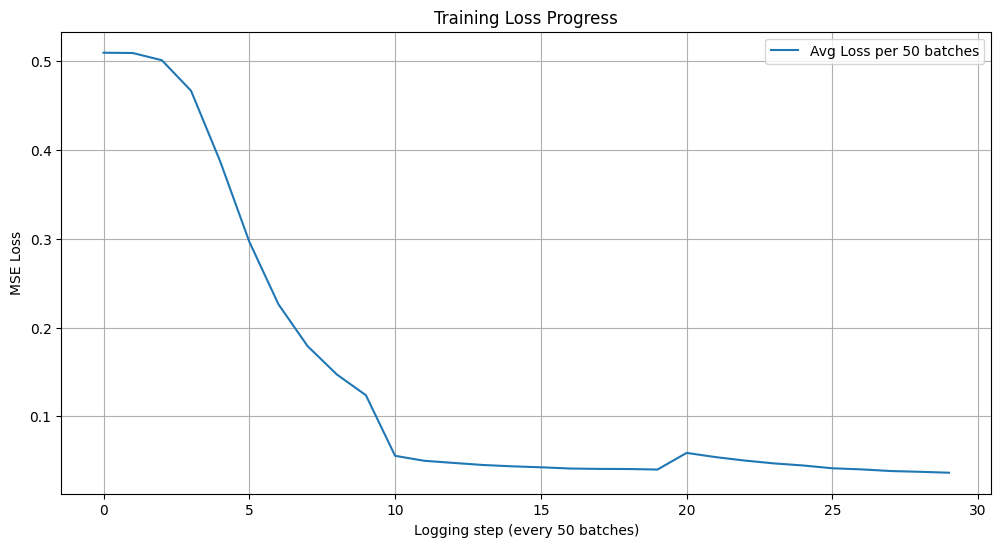

In [ ]:
mf_model, user_labels, product_labels = train_matrix_factorization(
    train_df,
    latent_dim=latent_dim,
    epochs=epochs,
    lr=lr,
    batch_size=batch_size
)

In [ ]:
torch.save(mf_model.state_dict(), models_dir / f'mf_model_latent_dim_{latent_dim}_epochs_{epochs}_lr_{lr}.pth')

with open(models_outputs_dir / 'mf' / 'user_labels.pkl', 'wb') as f:
    pickle.dump(user_labels, f)

with open(models_outputs_dir / 'mf' / 'product_labels.pkl', 'wb') as f:
    pickle.dump(product_labels, f)

In [ ]:
# Загружаем user_labels и product_labels
with open(models_outputs_dir / 'mf' / 'user_labels.pkl', "rb") as f:
    user_labels = pickle.load(f)

with open(models_outputs_dir / 'mf' / 'product_labels.pkl', "rb") as f:
    product_labels = pickle.load(f)

# Воссоздаём архитектуру модели
num_users = len(user_labels)
num_items = len(product_labels)

mf_model = MatrixFactorization(num_users, num_items, latent_dim).to(device)

# Загружаем веса модели
mf_model.load_state_dict(torch.load(models_dir / f'mf_model_latent_dim_{latent_dim}_epochs_{epochs}_lr_{lr}.pth'))

# Переводим модель в режим предсказания (инференса)
mf_model.eval()

MatrixFactorization(
  (user_factors): Embedding(370091, 512)
  (item_factors): Embedding(267600, 512)
)

In [ ]:
# Получаем список тестовых пользователей
user_ids = test_df['anon_id_encrypred'].unique()

len(user_ids[:len(user_ids) // 10])

12336

In [ ]:
# Получаем список тестовых пользователей
user_ids = test_df['anon_id_encrypred'].unique()

# Делаем рекомендации
user_recommendations_mf = recommend_mf_batch(
    user_ids=user_ids[:len(user_ids) // 10],
    model=mf_model,
    user_labels=user_labels,
    product_labels=product_labels,
    df=train_df,
    top_k_items=k,
    batch_size=2,
    filter_already_purchased=filter_already_purchased
)

with open(models_outputs_dir / 'mf' / 'user_recommendations_mf.pkl', 'wb') as f:
    pickle.dump(user_recommendations_mf, f)

Generating MF recommendations:   0%|          | 0/3256 [00:00<?, ?it/s]

In [85]:
with open(models_outputs_dir / 'mf' / 'user_recommendations_mf.pkl', "rb") as f:
    user_recommendations_mf = pickle.load(f)

In [86]:
dataset_mf = RecommendationDataset(user_recommendations=user_recommendations_mf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_mf, batch_size=batch_size, num_workers=0, 
                    collate_fn=lambda batch: collate_fn(batch, device='mps'))

In [87]:
precision_k = precision_at_k_gpu(loader=loader, k=k)
print(f'Precision@{k} for MF model: {precision_k:.8f}')

recall_k = recall_at_k_gpu(loader=loader, k=k)
print(f'Recall@{k} for MF model: {recall_k:8f}')

map_k = map_at_k_gpu(loader=loader, k=k)
print(f'MAP@{k} for MF model: {map_k:.8f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k)
print(f'NDCG@{k} for MF model: {ndcg_k:.8f}')

Precision@K:   0%|          | 0/20 [00:00<?, ?it/s]

Precision@10 for MF model: 0.00151912


Recall@K:   0%|          | 0/20 [00:00<?, ?it/s]

Recall@10 for MF model: 0.001501


MAP@K:   0%|          | 0/20 [00:00<?, ?it/s]

MAP@10 for MF model: 0.00053080


NDCG@K:   0%|          | 0/20 [00:00<?, ?it/s]

NDCG@10 for MF model: 0.00087391


In [88]:
log_model_results(model_name='Matrix Factorization', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, round_level=round_level,
                  hyperparameters={'top_k_items': k, 'latent_dim': latent_dim, 
                                   'filter_already_purchased': filter_already_purchased})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,10,0.003728,0.003641,0.001437,0.002435,None
1,Random,10,0.000046,0.000042,0.000009,0.000023,None
2,UBCF,10,0.003886,0.003787,0.001568,0.002602,"{'top_k_items': 10, 'top_n_similar_users': 20,..."
3,IBCF,10,0.002950,0.002940,0.001048,0.001697,"{'top_k_items': 10, 'top_n_similar_items': 20,..."
4,Matrix Factorization,10,0.001519,0.001501,0.000531,0.000874,"{'top_k_items': 10, 'latent_dim': 512, 'filter..."


In [89]:
# k = 5 # top_k_items
# n = 100 # n_components

# # Функция подготовки user-item матрицы с логарифмом
# def prepare_user_item_matrix(df):
#     """
#     Создает user-item матрицу с логарифмом количества покупок.
    
#     df: DataFrame с колонками ['anon_id_encrypred', 'product_id', 'base_price']
    
#     Возвращает:
#     - user_item_matrix (numpy 2D массив)
#     - users_mapping (словарь user_id -> индекс)
#     - items_mapping (словарь product_id -> индекс)
#     - reverse_users_mapping (словарь индекс -> user_id)
#     - reverse_items_mapping (словарь индекс -> product_id)
#     """
#     df = df.copy()
#     df['log_purchases'] = df.groupby(['anon_id_encrypred', 'product_id'])['base_price'].transform('count')
#     df['log_purchases'] = np.log1p(df['log_purchases'])  # log(1 + count)

#     # Уникальные пользователи и товары
#     users = df['anon_id_encrypred'].unique()
#     items = df['product_id'].unique()
    
#     # Создаем маппинги ID → индекс
#     users_mapping = {user: i for i, user in enumerate(users)}
#     items_mapping = {item: i for i, item in enumerate(items)}
    
#     # Обратные маппинги индекс → ID
#     reverse_users_mapping = {i: user for user, i in users_mapping.items()}
#     reverse_items_mapping = {i: item for item, i in items_mapping.items()}

#     # Создаем user-item матрицу
#     user_item_matrix = np.zeros((len(users), len(items)))
#     for _, row in df.iterrows():
#         user_idx = users_mapping[row['anon_id_encrypred']]
#         item_idx = items_mapping[row['product_id']]
#         user_item_matrix[user_idx, item_idx] = row['log_purchases']
    
#     return user_item_matrix, users_mapping, items_mapping, reverse_users_mapping, reverse_items_mapping

# # Функция вычисления SVD
# def compute_svd(user_item_matrix, n_components=n):
#     """
#     Вычисляет SVD-разложение user-item матрицы.
    
#     user_item_matrix: numpy 2D массив (пользователи x товары)
#     n_components: Количество скрытых факторов
    
#     Возвращает:
#     - предсказанную user-item матрицу (numpy 2D массив)
#     """
#     # Выполняем SVD
#     U, sigma, Vt = svds(user_item_matrix, k=n_components)
    
#     # Преобразуем sigma (диагональную) в квадратную матрицу
#     sigma = np.diag(sigma)

#     # Восстанавливаем предсказанную матрицу рейтингов R = U * Σ * V^T
#     predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    
#     return predicted_ratings

# # Функция рекомендаций
# def recommend_svd(user_id, predicted_matrix, users_mapping, items_mapping, reverse_items_mapping, top_k_items=k):
#     """
#     Для пользователя user_id предсказываем top-K товаров на основе предсказанной матрицы.
#     """
#     if user_id not in users_mapping:
#         return []
    
#     user_idx = users_mapping[user_id]
#     predicted_scores = predicted_matrix[user_idx]
#     top_item_indices = np.argsort(predicted_scores)[::-1][:top_k_items]
#     recommended_items = [reverse_items_mapping[i] for i in top_item_indices]
    
#     return recommended_items

# # Запуск модели
# user_item_matrix, users_mapping, items_mapping, reverse_users_mapping, reverse_items_mapping = prepare_user_item_matrix(train_df)
# predicted_ratings = compute_svd(user_item_matrix, n_components=n)


# user_recommendations_svd = {user: recommend_svd(user, predicted_ratings, users_mapping, items_mapping, reverse_items_mapping, top_k_items=k) 
#                             for user in tqdm(test_df['anon_id_encrypred'].unique())}

## Strong Models

### BERT4Rec

In [6]:
# Базовые импорты
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from pathlib import Path
import random
from collections import Counter, defaultdict
import itertools
import random
# from datetime import datetime
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt

# Импорты для RecSys
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
# from surprise import SVD, Dataset, Reader

import torch
import torch.nn as nn
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.set_per_process_memory_fraction(0.9) # Memory usage limit for MacOS
    torch.mps.empty_cache() 
else:
    device = torch.device("cpu")

# Метрики
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(911)
random.seed(911)

In [7]:
import gc
import weakref

for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps: # or obj.is_cuda
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache() # or torch.cuda.empty_cache()

#### BERT4Rec Base

In [ ]:
class BERT4RecDataset(Dataset):
    def __init__(self, sequences, max_len, mask_prob, num_items, pad_token=0, mask_token=None, is_train=True, external_targets=None):
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.num_items = num_items
        self.pad_token = pad_token
        self.mask_token = mask_token if mask_token is not None else num_items + 1
        self.is_train = is_train 
        self.external_targets = external_targets  # user_id -> true items (list or set)

        self.user_ids = []
        self.processed_sequences = []
        
        for user_id, seq in sequences:
            self.user_ids.append(user_id)
            truncated = seq[-self.max_len:] if len(seq) > self.max_len else seq
            padded = truncated + [self.pad_token] * (self.max_len - len(truncated))  # ПАДДИНГ СПРАВА
            self.processed_sequences.append(padded)

    def __len__(self):
        return len(self.processed_sequences)

    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        seq = self.processed_sequences[idx].copy()

        # === Валидационный режим ===
        if not self.is_train and self.external_targets is not None:
            input_seq = seq
            true_items = list(self.external_targets.get(user_id, []))[:self.max_len]

            # ПАДДИНГ СПРАВА для labels
            padded_labels = true_items + [-100] * (self.max_len - len(true_items))  # -100 — default ignore_index
            labels = torch.tensor(padded_labels, dtype=torch.long)

            attention_mask = [1 if x != self.pad_token else 0 for x in input_seq]
            position_ids = torch.arange(self.max_len, dtype=torch.long)

            return {
                "user_id": user_id,
                "input_ids": torch.tensor(input_seq, dtype=torch.long),
                "labels": labels,
                "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
                "position_ids": position_ids
            }


        # === Тренировочный режим (с гарантией min_masked = 1) ===
        input_seq = seq.copy()
        target_seq = [-100] * self.max_len

        candidate_idxs = [i for i, token in enumerate(seq) if token != self.pad_token]
        masked_idxs = [i for i in candidate_idxs if random.random() < self.mask_prob]

        # === min_masked = 1 ===
        if len(masked_idxs) == 0 and len(candidate_idxs) > 0:
            masked_idxs = [random.choice(candidate_idxs)]

        for i in masked_idxs:
            original_token = seq[i]
            prob = random.random()
            if prob < 0.9:
                input_seq[i] = self.mask_token
            elif prob < 0.99:
                input_seq[i] = random.randint(1, self.num_items)
            else:
                input_seq[i] = original_token
            target_seq[i] = original_token

        attention_mask = [1 if x != self.pad_token else 0 for x in input_seq]
        position_ids = torch.arange(self.max_len, dtype=torch.long)

        return {
            "user_id": user_id,
            "input_ids": torch.tensor(input_seq, dtype=torch.long),
            "labels": torch.tensor(target_seq, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "position_ids": position_ids
        }


In [29]:
df_sales = pd.read_parquet(interim_data_dir / 'df_sales.parquet')
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])
df_sales = df_sales.sort_values(by=['anon_id_encrypred', 'order_date'])

# Создаем маппинг оригинальных product_id в новые индексы от 1 до df_sales['product_id'].unique()
unique_product_ids = df_sales['product_id'].unique()
product_id_to_idx = {product_id: idx + 1 for idx, product_id in enumerate(unique_product_ids)}  # +1 чтобы начинать с 1

# Применяем маппинг к данным
df_sales['product_idx'] = df_sales['product_id'].map(product_id_to_idx)

threshold_level = 0.8
min_date = df_sales['order_date'].min()
max_date = df_sales['order_date'].max()

print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

total_days = (max_date - min_date).days
threshold_days = int(total_days * threshold_level)
threshold_date = min_date + pd.Timedelta(days=threshold_days)

print(f"Threshold date ({round(threshold_level * 100, 0)}%): {threshold_date}")

train_df = df_sales[df_sales['order_date'] < threshold_date]
test_df = df_sales[df_sales['order_date'] >= threshold_date]

# train_df.to_csv(interim_data_dir / 'train_data_by_threshold_date_for_bert4rec.csv', index=False)
# test_df.to_csv(interim_data_dir / 'test_data_by_threshold_date_for_bert4rec.csv', index=False)

# train_df = pd.read_csv(interim_data_dir / 'train_data_by_threshold_date_for_bert4rec.csv')
# test_df = pd.read_csv(interim_data_dir / 'test_data_by_threshold_date_for_bert4rec.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


test_user_to_true_items = test_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

print("Минимальный новый индекс:", df_sales['product_idx'].min())  # Должно быть 1
print("Максимальный новый индекс:", df_sales['product_idx'].max())  # Должно быть равно количеству уникальных товаров
print("Количество уникальных товаров:", df_sales['product_id'].nunique())
print(f"Всего пользователей: {len(df_sales['anon_id_encrypred'].unique())}")
print(f"Пользователей в тренировочной выборке: {len(train_df['anon_id_encrypred'].unique())}")
print(f"Пользователей в тестовой выборке: {len(test_df['anon_id_encrypred'].unique())}")

Min date: 2019-01-01 00:00:00
Max date: 2021-02-18 00:00:00
Threshold date (80.0%): 2020-09-15 00:00:00
Train shape: (2700604, 21)
Test shape: (767603, 21)
Минимальный новый индекс: 1
Максимальный новый индекс: 306664
Количество уникальных товаров: 306664
Всего пользователей: 453195
Пользователей в тренировочной выборке: 370091
Пользователей в тестовой выборке: 195339


In [30]:
# Группируем по пользователям и считаем длину последовательности для каждого
user_sequence_lengths = df_sales.groupby('anon_id_encrypred').size()
percentiles = user_sequence_lengths.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
# Находим максимальную длину последовательности
max_sequence_length = user_sequence_lengths.max()
print("Перцентили длин последовательностей:")
print(percentiles)
print(f"Максимальная длина последовательности: {max_sequence_length}")

Перцентили длин последовательностей:
0.25     1.0
0.50     2.0
0.75     6.0
0.90    17.0
0.95    30.0
0.99    90.0
dtype: float64
Максимальная длина последовательности: 2446


In [31]:
# Создаём последовательности покупок для каждого пользователя
train_sequences = train_df.groupby('anon_id_encrypred')['product_idx'].apply(list).to_dict()
test_sequences = test_df.groupby('anon_id_encrypred')['product_idx'].apply(list).to_dict()

# Проверяем пример последовательности для одного пользователя
print(f"Пример последовательности для пользователя {list(train_sequences.keys())[0]}: {train_sequences[list(train_sequences.keys())[0]]}")

Пример последовательности для пользователя qqwrtrxq: [1, 2, 3]


In [ ]:
max_len = 15          # Максимальная длина последовательности
mask_prob = 0.5       # Вероятность маскирования
num_items = df_sales['product_idx'].nunique()  # Количество уникальных товаров

# Преобразуем словари последовательностей в списки кортежей (user_id, sequence)
train_sequences_list = list(train_sequences.items())
test_sequences_list = list(test_sequences.items())

train_dataset = BERT4RecDataset(
    sequences=train_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=True
)

test_dataset = BERT4RecDataset(
    sequences=train_sequences_list,     # <-- train для input’ов
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=False,
    external_targets=test_sequences  # <-- таргеты из test_df
)


batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [33]:
# Пример использования DataLoader
for batch in train_loader:
    print('One object from `train_loader`')
    user_ids = batch['user_id'][0]
    input_ids = batch['input_ids'][0]
    labels = batch['labels'][0]
    attention_mask = batch['attention_mask'][0]
    position_ids = batch['position_ids'][0]
    
    print("User ID:", user_ids)
    print("Input IDs:", input_ids)
    print("Labels:", labels)
    print("Attention Mask:", attention_mask)
    print("Position IDs:", position_ids)
    break  # Остановимся после первого батча для примера

print()

for batch in test_loader:
    print('One object from `test_dataset`')
    user_ids = batch['user_id'][0]
    input_ids = batch['input_ids'][0]
    labels = batch['labels'][0]
    attention_mask = batch['attention_mask'][0]
    position_ids = batch['position_ids'][0]
    
    print("User ID:", user_ids)
    print("Input IDs:", input_ids)
    print("Labels:", labels)
    print("Attention Mask:", attention_mask)
    print("Position IDs:", position_ids)
    break  # Остановимся после первого батча для примера

One object from `train_loader`
User ID: wyyypqqtpvsvsytu
Input IDs: tensor([306665,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0])
Labels: tensor([158158,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100,   -100,   -100,   -100,   -100])
Attention Mask: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Position IDs: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

One object from `test_dataset`
User ID: qqwrtrxq
Input IDs: tensor([1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Labels: tensor([   4,    5, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100])
Attention Mask: tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Position IDs: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])


In [48]:
class BERT4RecModel(nn.Module):
    def __init__(self,
                 num_items,
                 max_len,
                 embedding_dim=256,
                 num_layers=6,
                 num_heads=4,
                 dropout=0.1,
                 ffn_dim=1024):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_items = num_items
        self.max_len = max_len

        # PAD = 0, items = 1..num_items, MASK = num_items+1
        self.item_embeddings = nn.Embedding(num_items + 2,
                                            embedding_dim,
                                            padding_idx=0)
        self.position_embeddings = nn.Embedding(max_len, embedding_dim)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer,
                                              num_layers=num_layers)

        # ——— Новая классифицирующая голова ———
        # Проецируем обратно в embedding_dim, чтобы можно было dot-product'ом
        self.fc_head = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 2),
            nn.GELU(),
            nn.LayerNorm(embedding_dim * 2),
            nn.Linear(embedding_dim * 2, embedding_dim, bias=False),
            # nn.LayerNorm(embedding_dim),  
        )
        # bias для logits по словарю
        self.vocab_bias = nn.Parameter(torch.zeros(num_items + 2))

        # weight-tying: последний Linear выдаёт embedding_dim,
        # а дальше dot(item_emb.weight.T) дает logits по vocab
        # (embedding_dim == self.item_embeddings.embedding_dim)

        self._init_weights()

    def _init_weights(self):
        # эмбеддинги
        nn.init.xavier_uniform_(self.item_embeddings.weight)
        # nn.init.normal_(self.item_embeddings.weight, 0.0, 0.02)
        nn.init.normal_(self.position_embeddings.weight, 0.0, 0.02)

        # трансформер
        for layer in self.transformer.layers:
            nn.init.xavier_uniform_(layer.self_attn.in_proj_weight)
            nn.init.xavier_uniform_(layer.self_attn.out_proj.weight)
            nn.init.xavier_uniform_(layer.linear1.weight)
            nn.init.xavier_uniform_(layer.linear2.weight)

        # голова
        nn.init.xavier_uniform_(self.fc_head[0].weight)
        nn.init.xavier_uniform_(self.fc_head[3].weight)
        nn.init.zeros_(self.vocab_bias)

    def forward(self, input_ids, attention_mask, position_ids):
        B, L = input_ids.size()
        # 1) Embeddings + scale
        item_embeds = self.item_embeddings(input_ids)             # (B,L,dim)
        pos_embeds  = self.position_embeddings(position_ids)      # (L,dim) -> broadcast
        x = (item_embeds + pos_embeds) * math.sqrt(self.embedding_dim)
        x = self.layer_norm(x)
        x = self.dropout(x)

        # 2) Causal + padding masks
        src_key_padding_mask = (attention_mask == 0)              # (B,L)

        # 3) Transformer
        x = self.transformer(x, src_key_padding_mask=src_key_padding_mask)  # (B,L,dim)

        # 4) Head → back to embedding space
        h = self.fc_head(x)                                      # (B,L,dim)

        # 5) Dot-product with item_embeddings + bias → logits
        logits = torch.matmul(h, self.item_embeddings.weight.T)  # (B,L,num_items+2)
        logits = logits + self.vocab_bias                        # broadcast bias

        return logits

In [49]:
def train_model(
    model: nn.Module,
    train_loader,
    val_loader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    save_path: str,
    num_epochs: int = 5,
    log_interval: int = 50,
    scheduler    = None,
):
    """
    Тренирует модель с выводом прогресса через tqdm и периодическим логированием лосса.
    Возвращает модель и историю лоссов.
    """
    criterion = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1) # label_smoothing=0.1 размывание таргета
    best_val_loss = float("inf")

    train_loss_history = []
    val_loss_history = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        # running_loss = 0.0
        running, acc_steps = 0.0, 0

        for n,p in model.named_parameters():
            assert torch.all(torch.isfinite(p)), f"NaN в параметре {n}"


        # оборачиваем сам loader, а затем делаем enumerate над tqdm-ом
        pbar_train = tqdm(train_loader, total=len(train_loader),
                          desc=f"[Epoch {epoch}/{num_epochs}] Train")
        for batch_idx, batch in enumerate(pbar_train, 1):
            try:
                input_ids      = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                position_ids   = batch['position_ids'].to(device)
                labels         = batch['labels'].to(device)

                # === ✅ ДОПОЛНИТЕЛЬНАЯ ПРОВЕРКА ПЕРЕД LOSS ===
                # print(f"[Batch {batch_idx}] input_ids: min={input_ids.min().item()}, max={input_ids.max().item()}")
                # print(f"[Batch {batch_idx}] labels:    min={labels[labels != -100].min().item() if (labels != -100).any() else 'n/a'}, "
                #     f"max={labels[labels != -100].max().item() if (labels != -100).any() else 'n/a'}")

                # Проверка на допустимые значения
                assert torch.all((labels == -100) | ((labels > 0) & (labels < num_items + 1))), \
                    f"Invalid label value found! batch_idx={batch_idx}"

                assert input_ids.max() < num_items + 2, f"input_ids contain invalid token! batch_idx={batch_idx}"

                if not (labels != -100).any():
                    print(f"[Batch {batch_idx}] All masked, skipping")
                    pbar_train.update(1)
                    continue

                optimizer.zero_grad()

                outputs = model(input_ids, attention_mask, position_ids)
                loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))

                if not torch.isfinite(loss):
                    print(f"!!! NaN loss at epoch {epoch} batch {batch_idx}")

                    for name, p in model.named_parameters():
                        if not torch.all(torch.isfinite(p)):
                            bad = (~torch.isfinite(p)).sum().item()
                            print(f"  → {name}: {bad} bad entries")
                    raise RuntimeError("Stop: loss became NaN")
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

                running += loss.item()
                acc_steps += 1

                if batch_idx % 500 == 0:
                    print(f"[Batch {batch_idx}] shape: input_ids={input_ids.shape}, labels={labels.shape}, outputs={outputs.shape}")
                    current_lr = scheduler.get_last_lr()[0]
                    print(f"[Batch {batch_idx}] lr = {current_lr:.8f}")


                # log n первых/каждый log_interval
                if batch_idx == 1 or (acc_steps % log_interval == 0):
                    avg = running / acc_steps
                    pbar_train.set_postfix(batch_loss=f"{avg:.4f}")
                    train_loss_history.append(avg)
                    running, acc_steps = 0.0, 0

            except Exception as e:
                print(f"Error at batch {batch_idx}: {e}")


        # ---- Validation ----
        model.eval()
        # val_running = 0.0
        val_running, val_batches = 0.0, 0

        with torch.no_grad():
            pbar_val = tqdm(val_loader, total=len(val_loader),
                            desc=f"[Epoch {epoch}/{num_epochs}] Val  ")
            for batch in pbar_val:
                input_ids      = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                position_ids   = batch['position_ids'].to(device)
                labels         = batch['labels'].to(device)

                if (labels != -100).any():           # есть валид-таргеты
                    outputs = model(input_ids, attention_mask, position_ids)
                    loss    = criterion(
                        outputs.view(-1, outputs.size(-1)),
                        labels.view(-1)
                    )
                    val_running += loss.item()
                    val_batches += 1
                    pbar_val.set_postfix(val_loss=f"{loss.item():.4f}")
                else:
                    pbar_val.set_postfix(val_loss="skip")

        avg_val = val_running / val_batches if val_batches else float("nan")
        val_loss_history.append(avg_val)
        print(f"Epoch {epoch}: val_loss = {avg_val:.4f}")

        # сохраняем лучшую модель
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), save_path)
            print(f"→ saved new best model  (val_loss {best_val_loss:.4f})\n")

    return model, train_loss_history, val_loss_history

In [50]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

embedding_dim=1024
num_layers=12
num_heads=8
ffn_dim=4096
dropout=0.1
lr=1e-4
log_interval=100

model = BERT4RecModel(
    num_items    = num_items,
    max_len      = max_len,
    embedding_dim=embedding_dim,
    num_layers   =num_layers,
    num_heads    =num_heads,
    ffn_dim      =ffn_dim,
    dropout      =dropout
).to(device)

optimizer = AdamW(model.parameters(),
                  lr=lr,
                  weight_decay=1e-3)

num_epochs   = 3
total_steps  = num_epochs * len(train_loader)
warmup_steps = int(0.1 * total_steps)

scheduler = LambdaLR(optimizer,
    lr_lambda=lambda step: (step / warmup_steps if step < warmup_steps
        else max(0.0, (total_steps - step) / float(max(1, total_steps - warmup_steps)))
    )
)

save_path = models_dir / f'bert4rec_model_embedding_dim_{embedding_dim}_epochs_{num_epochs}_lr_{lr}_max_len_{max_len}_mask_prob_{mask_prob}_num_layers_{num_layers}_num_heads_{num_heads}_ffn_dim_{ffn_dim}_dropout_{dropout}_num_items_{num_items}.pth'

In [51]:
model

BERT4RecModel(
  (item_embeddings): Embedding(306666, 1024, padding_idx=0)
  (position_embeddings): Embedding(15, 1024)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=4096, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=4096, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_head): Sequential(
    (0): Linear(in_fea

In [52]:
trained_model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    log_interval=log_interval,
    save_path=save_path,
    scheduler=scheduler
)

torch.save(trained_model.state_dict(), models_dir / f'LAST_EPOCH_bert4rec_model_embedding_dim_{embedding_dim}_epochs_{num_epochs}_lr_{lr}_max_len_{max_len}_mask_prob_{mask_prob}_num_layers_{num_layers}_num_heads_{num_heads}_ffn_dim_{ffn_dim}_dropout_{dropout}_num_items_{num_items}.pth')

print(f"Последний train loss = {train_losses[-1]:.4f}")
print(f"Последний val   loss = {val_losses[-1]:.4f}")

[Epoch 1/3] Train:   0%|          | 0/11566 [00:00<?, ?it/s]

[Batch 500] shape: input_ids=torch.Size([32, 15]), labels=torch.Size([32, 15]), outputs=torch.Size([32, 15, 306666])
[Batch 500] lr = 0.00001441


KeyboardInterrupt: 

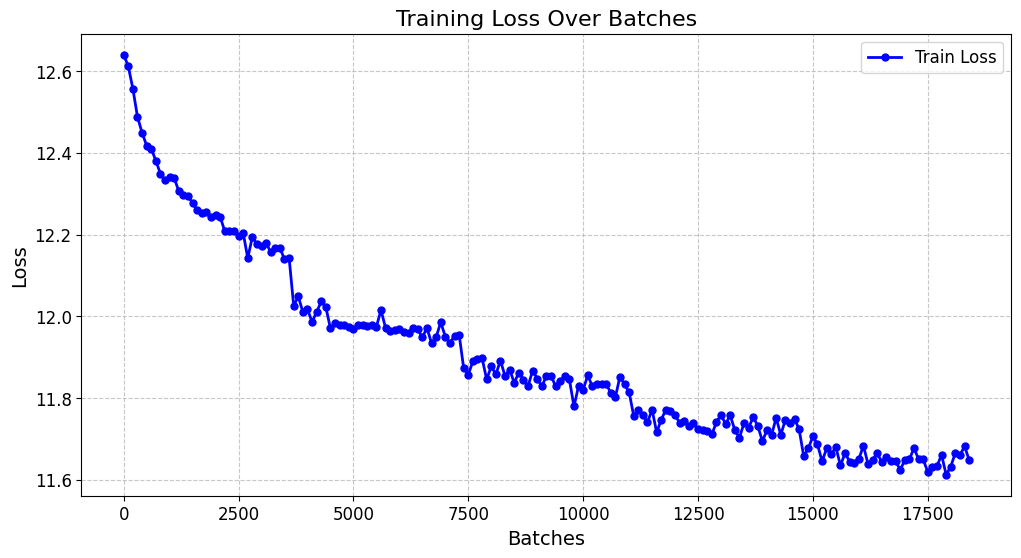

In [ ]:
def plot_train_loss(train_losses, log_interval, name='Loss Over Batches'):
    """
    Визуализация train_losses.
    
    :param train_losses: Список значений потерь на тренировке.
    :param log_interval: Интервал логирования (для корректной оси X).
    """
    plt.figure(figsize=(12, 6))
    
    # Ось X: количество батчей
    x = [i * log_interval for i in range(len(train_losses))]
    
    # Отрисовка графика
    plt.plot(x, train_losses, label='Train Loss', marker='o', color='blue', linestyle='-', linewidth=2, markersize=5)
    
    # Настройки графика
    plt.title(name, fontsize=16)
    plt.xlabel('Batches', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Отображение графика
    plt.show()

# Пример использования после обучения
plot_train_loss(train_losses, log_interval=log_interval, name='Training Loss Over Batches')
plot_train_loss(val_losses, log_interval=100, name='Validation Loss Over Batches')

#### BERT4Rec + Content embeddings

In [18]:
filtered.iloc[2]['photo_analytics']

'https://st-cdn.tsum.com/int/height/1526//i/1e/32/23/32/1e322332-68be-3e58-94eb-e908a6dc7505.jpg'

In [19]:
filtered.iloc[3]['photo_analytics']

'https://st-cdn.tsum.com/int/height/1526//i/03/24/d3/2f/0324d32f-0c3a-3823-bff0-6f8c5ec213fe.jpg'

In [24]:
filtered[filtered['articul_encrypred']=='pyrtvyt']

,anon_id_encrypred,articul_encrypred,color_base,sizeid,size_title,order_date,store,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,base_price,net_price,sale_percentage,slug,photo_analytics
163213,wyyypqqtprrswrqy,pyrtvyt,Бежевый,105,105,2019-05-20,T,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,11579616,2016-12-12,58200.0,58200.00,0.000000,1835785-zamshevyi-remen-loro-piana-svetlo-bezh...,https://st-cdn.tsum.com/int/height/1526//i/cd/...
268731,wyyypqqtpryssyvw,pyrtvyt,Бежевый,105,105,2019-09-03,T,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,11034409,2016-04-10,62050.0,48912.83,0.211719,1835785-zamshevyi-remen-loro-piana-bezhevyi-id...,https://st-cdn.tsum.com/int/height/1526//i/23/...
464562,wyyypqqtptsrtxut,pyrtvyt,Бежевый,105,105,2019-04-23,T,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,11034409,2016-04-10,58200.0,58200.00,0.000000,1835785-zamshevyi-remen-loro-piana-bezhevyi-id...,https://st-cdn.tsum.com/int/height/1526//i/23/...
2865980,wyyyrqqtqqstyqux,pyrtvyt,Бежевый,105,105,2019-03-30,E,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,11579616,2016-12-12,58200.0,58200.00,0.000000,1835785-zamshevyi-remen-loro-piana-svetlo-bezh...,https://st-cdn.tsum.com/int/height/1526//i/cd/...
3033917,wyyysqqtqptxquwv,pyrtvyt,Бежевый,105,105,2020-02-17,T,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,11034409,2016-04-10,62050.0,62050.00,0.000000,1835785-zamshevyi-remen-loro-piana-bezhevyi-id...,https://st-cdn.tsum.com/int/height/1526//i/23/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574895,wyyypqqtqwwvsqwu,pyrtvyt,Хаки,95,95,2019-06-07,T,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,12544421,2018-01-23,58200.0,58200.00,0.000000,1835785-zamshevyi-remen-loro-piana-khaki-id125...,https://st-cdn.tsum.com/int/height/1526//i/26/...
1781541,wyyypqqtqxvusxuy,pyrtvyt,Хаки,95,95,2020-01-31,E,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,12544421,2018-01-23,37250.0,37250.00,0.000000,1835785-zamshevyi-remen-loro-piana-khaki-id125...,https://st-cdn.tsum.com/int/height/1526//i/26/...
2337530,wyyypvqpqqsxtypq,pyrtvyt,Хаки,95,95,2020-12-31,E,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,12544421,2018-01-23,24850.0,18200.00,0.267606,1835785-zamshevyi-remen-loro-piana-khaki-id125...,https://st-cdn.tsum.com/int/height/1526//i/26/...
2612345,wyyypvqpquxrwqvq,pyrtvyt,Хаки,95,95,2020-12-13,E,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,12544421,2018-01-23,24850.0,24850.00,0.000000,1835785-zamshevyi-remen-loro-piana-khaki-id125...,https://st-cdn.tsum.com/int/height/1526//i/26/...


In [29]:
len(df_products['photo_analytics'].unique())

306672

In [22]:
filtered[filtered['articul_encrypred']=='pyrtvyt'].iloc[0]['photo_analytics']

'https://st-cdn.tsum.com/int/height/1526//i/cd/16/40/11/cd164011-06a5-3837-b250-bbaf49a8ba87.jpg'

In [23]:
filtered[filtered['articul_encrypred']=='pyrtvyt'].iloc[1]['photo_analytics']

'https://st-cdn.tsum.com/int/height/1526//i/23/77/ab/cd/2377abcd-c0d3-35bf-9a87-72e340d19c3f.jpg'

In [ ]:
df_sales = pd.read_parquet(interim_data_dir / 'df_sales.parquet')

# Группировка по color_base и articul_encrypred
grouped = df_sales.groupby(['color_base', 'articul_encrypred'])

# Фильтрация групп, где есть разные sizeid и разные product_id
filtered = grouped.filter(
    lambda x: x['sizeid'].nunique() > 1 and x['product_id'].nunique() > 1
)

# Сортировка для удобства
filtered = filtered.sort_values(by=['color_base', 'articul_encrypred', 'sizeid'])

# Просмотр нескольких строк
filtered.head(5)

,anon_id_encrypred,articul_encrypred,color_base,sizeid,size_title,order_date,store,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,base_price,net_price,sale_percentage,slug,photo_analytics
3400023,wyyysqqtqqxrwrvs,pstrpxs,Бежевый,41-42,41-42,2019-03-27,E,Falke,Товары для мужчин,"Домашняя, пляжная одежда",Чулочно-носочные изделия,Носки,Хлопковые носки Tiago,6150794,2014-10-11,2140.0,2007.82,0.061766,1253192-khlopkovye-noski-tiago-falke-svetlo-be...,https://st-cdn.tsum.com/int/height/1526//i/ea/...
1876155,wyyypqqtqypstvpt,pstrpxs,Бежевый,45-46,45-46,2019-03-28,E,Falke,Товары для мужчин,"Домашняя, пляжная одежда",Чулочно-носочные изделия,Носки,Хлопковые носки Tiago,6118244,2014-10-09,2140.0,2140.00,0.000000,1253192-khlopkovye-noski-tiago-falke-svetlo-be...,https://st-cdn.tsum.com/int/height/1526//i/5a/...
3040626,wyyysqqtqptysyvy,pxuuvtv,Бежевый,0,44,2019-03-04,T,James Perse,Товары для мужчин,Одежда,Одежда джерси,Поло джерси,Хлопковое поло,12417434,2017-11-24,7995.0,4340.83,0.457057,1944757-khlopkovoe-polo-james-perse-bezhevyi-i...,https://st-cdn.tsum.com/int/height/1526//i/1e/...
2612892,wyyypvqpquxryvwp,pxuuvtv,Бежевый,5,54,2020-04-08,E,James Perse,Товары для мужчин,Одежда,Одежда джерси,Поло джерси,Хлопковое поло,12046519,2017-05-30,15450.0,12360.00,0.200000,1944757-khlopkovoe-polo-james-perse-bezhevyi,https://st-cdn.tsum.com/int/height/1526//i/03/...
163213,wyyypqqtprrswrqy,pyrtvyt,Бежевый,105,105,2019-05-20,T,Loro Piana,Товары для мужчин,Аксессуары из кожи,Ремни,Ремень классический,Замшевый ремень,11579616,2016-12-12,58200.0,58200.00,0.000000,1835785-zamshevyi-remen-loro-piana-svetlo-bezh...,https://st-cdn.tsum.com/int/height/1526//i/cd/...


In [ ]:
df_sales = pd.read_parquet(interim_data_dir / 'df_sales.parquet')[['anon_id_encrypred', 'articul_encrypred', 'color_base', 'sizeid',
       'size_title', 'order_date', 'store', 'brand', 'ktt1', 'ktt2', 'ktt3',
       'ktt4', 'title', 'product_id', 'product_created_at', 'base_price',
       'net_price', 'sale_percentage', 'slug', 'photo_analytics']]
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])
df_sales = df_sales.sort_values(by=['anon_id_encrypred', 'order_date'])

# Создаем маппинг оригинальных product_id в новые индексы от 1 до df_sales['product_id'].unique()
unique_product_ids = df_sales['product_id'].unique()
product_id_to_idx = {product_id: idx + 1 for idx, product_id in enumerate(unique_product_ids)}  # +1 чтобы начинать с 1

# Применяем маппинг к данным
df_sales['product_idx'] = df_sales['product_id'].map(product_id_to_idx)

threshold_level = 0.8
min_date = df_sales['order_date'].min()
max_date = df_sales['order_date'].max()

print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

total_days = (max_date - min_date).days
threshold_days = int(total_days * threshold_level)
threshold_date = min_date + pd.Timedelta(days=threshold_days)

print(f"Threshold date ({round(threshold_level * 100, 0)}%): {threshold_date}")

train_df = df_sales[df_sales['order_date'] < threshold_date]
test_df = df_sales[df_sales['order_date'] >= threshold_date]

# train_df.to_csv(interim_data_dir / 'train_data_by_threshold_date_for_bert4rec.csv', index=False)
# test_df.to_csv(interim_data_dir / 'test_data_by_threshold_date_for_bert4rec.csv', index=False)

# train_df = pd.read_csv(interim_data_dir / 'train_data_by_threshold_date_for_bert4rec.csv')
# test_df = pd.read_csv(interim_data_dir / 'test_data_by_threshold_date_for_bert4rec.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


test_user_to_true_items = test_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

print("Минимальный новый индекс:", df_sales['product_idx'].min())  # Должно быть 1
print("Максимальный новый индекс:", df_sales['product_idx'].max())  # Должно быть равно количеству уникальных товаров
print("Количество уникальных товаров:", df_sales['product_id'].nunique())
print(f"Всего пользователей: {len(df_sales['anon_id_encrypred'].unique())}")
print(f"Пользователей в тренировочной выборке: {len(train_df['anon_id_encrypred'].unique())}")
print(f"Пользователей в тестовой выборке: {len(test_df['anon_id_encrypred'].unique())}")

In [ ]:
# Функция для параллельной генерации рекомендаций (на входе батч из тестового DataLoader)
def generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=10, device=device):
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        position_ids = position_ids.to(device)
        
        # Получаем выходы модели: [B, seq_len, num_items+1]
        outputs = model(input_ids, attention_mask, position_ids)
        # Берем логиты последнего токена (последний временной шаг)
        logits = outputs[:, -1, :]  # размер [B, num_items+1]
        # Выбираем топ-k рекомендаций для каждого примера
        recs = torch.topk(logits, k=k, dim=-1).indices
    return recs

# Функция для последовательной генерации рекомендаций для одного пользователя
def generate_sequential_recommendations(model, initial_sequence, max_len, k=10, device=device):
    """
    Генерирует последовательные рекомендации (авторегрессивно) для одного пользователя.
    
    :param initial_sequence: Исходная последовательность (список int) без паддинга.
    :param max_len: Максимальная длина последовательности, с которой обучалась модель.
    :param k: Количество генерируемых рекомендаций.
    :param device: Устройство.
    :return: Список сгенерированных рекомендаций.
    """
    model.eval()
    generated = []
    current_seq = initial_sequence.copy()
    
    with torch.no_grad():
        for _ in range(k):
            # Если длина последовательности меньше max_len – дополняем слева паддингом (значение 0)
            if len(current_seq) < max_len:
                padded_seq = [0] * (max_len - len(current_seq)) + current_seq
            else:
                padded_seq = current_seq[-max_len:]
            
            input_ids = torch.tensor(padded_seq, dtype=torch.long, device=device).unsqueeze(0)
            attention_mask = (input_ids != 0).long()
            position_ids = torch.arange(max_len, dtype=torch.long, device=device).unsqueeze(0)
            
            outputs = model(input_ids, attention_mask, position_ids)  # [1, max_len, num_items+1]
            logits = outputs[:, -1, :]  # [1, num_items+1]
            next_token = torch.topk(logits, k=1, dim=-1).indices.squeeze().item()
            generated.append(next_token)
            current_seq.append(next_token)
    
    return generated

In [ ]:
def run_parallel_inference(model, inference_loader, k=10, device=device):
    """
    Запускает инференс на inference_loader и получает топ-K рекомендаций для каждого пользователя.
    
    :param model: Обученная модель BERT4Rec
    :param inference_loader: DataLoader без маскированных токенов (данные из train)
    :param k: Количество рекомендаций
    :param device: Устройство (CPU/GPU)
    :return: Список предсказанных рекомендаций для всех пользователей
    """
    model.eval()
    all_recommendations = []

    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Parallel Inference"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            position_ids = batch["position_ids"].to(device)

            # Генерируем k рекомендаций
            recs = generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=k, device=device)
            
            all_recommendations.extend(recs.cpu().tolist())

    return all_recommendations


def run_sequential_inference(model, inference_loader, max_len, k=10, device=device):
    """
    Запускает последовательный инференс: для каждого пользователя из inference_loader извлекается исходная (непадённая) последовательность,
    и генерируется последовательность рекомендаций методом авторегрессии.
    
    :param model: Обученная модель BERT4Rec.
    :param inference_loader: DataLoader с данными (is_train=False).
    :param max_len: Максимальная длина последовательности.
    :param k: Количество генерируемых рекомендаций для каждого пользователя.
    :param device: Устройство.
    :return: Словарь вида {user_id: [последовательность рекомендаций]}.
    """
    model.eval()
    user_recs = {}
    
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Sequential Inference"):
            input_ids = batch['input_ids']           # [B, max_len]
            attention_mask = batch['attention_mask']   # [B, max_len]
            user_ids = batch['user_id']                # список user_id
            
            # Для каждого пользователя в батче извлекаем исходную последовательность без паддинга
            for i in range(input_ids.shape[0]):
                # Переходим на CPU, чтобы легко работать со списками
                seq = input_ids[i].cpu().tolist()
                mask = attention_mask[i].cpu().tolist()
                # Извлекаем только те токены, где mask==1 (непаддинговые элементы)
                initial_seq = [token for token, m in zip(seq, mask) if m == 1]
                recs = generate_sequential_recommendations(model, initial_seq, max_len, k=k, device=device)
                user_recs[user_ids[i]] = recs

    return user_recs

In [ ]:
# Используем train-данные для генерации предсказаний
inference_dataset = BERT4RecDataset(sequences=train_sequences_list, max_len=max_len, mask_prob=0.0, num_items=num_items, is_train=False)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def map_recommendations_to_users(user_ids, recommendations):
    """
    Преобразует список рекомендаций в словарь {user_id: recommendations}.

    :param user_ids: Список ID пользователей из inference_loader
    :param recommendations: Список рекомендаций из parallel_recs
    :return: Словарь {user_id: [recommendations]}
    """
    user_to_recs = {user: recs for user, recs in zip(user_ids, recommendations)}
    return user_to_recs

# Получаем список пользователей из inference_loader
user_ids = inference_loader.dataset.user_ids

In [ ]:
# Параллельные предсказания (Batch Inference)
parallel_recs = run_parallel_inference(model, inference_loader, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_parallel_recs = map_recommendations_to_users(user_ids, parallel_recs)

In [ ]:
# Последовательные предсказания (Sequential Inference)
sequential_recs = run_sequential_inference(model, inference_loader, max_len=max_len, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_sequential_recs = map_recommendations_to_users(user_ids, sequential_recs)

In [ ]:
# from torch_lr_finder import TrainDataLoaderIter

# criterion = torch.nn.CrossEntropyLoss(ignore_index=0) # игнорим паддинги

# optimizer = torch.optim.AdamW(model.parameters(), 
#                              # lr=1e-5, # Было 1e-4
#                              weight_decay=0.01)

# class CustomTrainDataLoaderIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         # Извлекаем данные из батча
#         inputs = {
#             'input_ids': batch_data['input_ids'],          # Input IDs
#             'attention_mask': batch_data['attention_mask'], # Attention Mask
#             'position_ids': batch_data['position_ids']     # Position IDs
#         }
#         labels = batch_data['labels']  # Labels
#         return inputs, labels


# # Создаем кастомный итератор
# train_iter = CustomTrainDataLoaderIter(train_loader)

# # Инициализация LRFinder
# lr_finder = LRFinder(model, optimizer, criterion)

# # Запуск поиска learning rate
# lr_finder.range_test(train_iter, end_lr=0.1, num_iter=100)

# # Визуализация результатов
# lr_finder.plot()

# # Сброс состояния модели
# lr_finder.reset()

In [ ]:
# # Создаем экземпляр модели
# model = BERT4RecModel(
#     num_items=num_items,
#     max_len=max_len,
#     embedding_dim=256,
#     num_layers=4,       # Кол-во атеншн слоёв (Аттеншн + лин + нелин + дропаут)
#     num_heads=8,        # Головы аттеншн слоёв
#     dropout=0.1
# ).to(device)

# # Загружаем веса
# model.load_state_dict(torch.load(models_path / 'bert4rec_embedding_dim_256_num_layers_3_num_heads_4_dropout_001_lr_1e5_base.pth'))

# # Переводим модель в режим оценки
# model.eval()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from tqdm.auto import tqdm
import random

# Дополнительные импорты для работы с изображениями и текстом
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
import torchvision.models as models
from sentence_transformers import SentenceTransformer

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.mps.set_per_process_memory_fraction(0.95)  # Ограничение памяти до 80%
torch.mps.empty_cache()

#########################
# 1. Предобработка метаданных
#########################

def compute_product_meta_features(df, meta_dim=128, device="cpu"):
    """
    Вычисляет мета-вектор для каждого уникального продукта.
    Используются признаки: brand, title, color_base, ktt1 (категория) и изображение из photo_analytics.
    """
    # Инициализируем модель для текстовых эмбеддингов
    text_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Инициализируем предобученную модель для изображений (удаляем последний классификационный слой)
    image_model = models.resnet18(pretrained=True)
    image_model.fc = nn.Identity()
    image_model = image_model.to(device)
    image_model.eval()  # замораживаем веса для извлечения признаков
    
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    product_meta = {}
    unique_products = df.drop_duplicates(subset=['product_idx'])
    
    for _, row in tqdm(unique_products.iterrows(), desc='Data preparing', total=unique_products.shape[0]):
        product_idx = row['product_idx']
        # Объединяем текстовые признаки
        text_input = f"{row['brand']} {row['title']} {row['color_base']} {row['ktt1']}"
        text_feat = text_model.encode(text_input, convert_to_tensor=True).to(device)
        
        # Извлекаем признаки изображения
        try:
            response = requests.get(row['photo_analytics'], timeout=5)
            image = Image.open(BytesIO(response.content)).convert('RGB')
            image = image_transform(image).unsqueeze(0).to(device)  # переносим на нужное устройство
            with torch.no_grad():
                image_feat = image_model(image).squeeze(0)
        except Exception as e:
            # Если не удалось получить изображение, используем вектор нулей (размер 512)
            image_feat = torch.zeros(512, device=device)
        
        # Конкатенируем текстовые и визуальные признаки
        meta_feat = torch.cat([text_feat, image_feat], dim=0)
        # Если размер полученного вектора не совпадает с meta_dim, применяем линейную проекцию
        if meta_feat.shape[0] != meta_dim:
            proj = nn.Linear(meta_feat.shape[0], meta_dim).to(device)
            meta_feat = proj(meta_feat.unsqueeze(0)).squeeze(0)
        product_meta[product_idx] = meta_feat
    
    return product_meta

# Пример: объединяем train_df и test_df (или используем df_sales, если он есть)
import pandas as pd
# df_sales = pd.concat([train_df, test_df], ignore_index=True)  # если необходимо объединить

# Предположим, что у вас уже есть df_sales с нужными столбцами
product_meta_dict = compute_product_meta_features(df_sales, meta_dim=128)

# Количество уникальных товаров
num_items = df_sales['product_idx'].nunique()

# Формируем матрицу весов для мета-эмбеддингов размерности (num_items+2, meta_dim)
# +2 для pad (индекс 0) и mask токена (индекс num_items+1)
meta_dim = 128
meta_weights = torch.zeros(num_items + 2, meta_dim)
# Заполняем веса для индексов от 1 до num_items (предполагается, что product_idx начинается с 1)
for idx in range(1, num_items + 1):
    if idx in product_meta_dict:
        meta_weights[idx] = product_meta_dict[idx]
    else:
        meta_weights[idx] = torch.zeros(meta_dim)
# Для токена 0 (pad) и токена mask (num_items+1) оставляем нули

#########################
# 2. Модификация модели BERT4Rec
#########################

class BERT4RecModel(nn.Module):
    def __init__(self, num_items, max_len, meta_embedding_weights, embedding_dim=512, num_layers=6, num_heads=8, 
                 dropout=0.1, ffn_dim=2048):
        """
        Модель BERT4Rec с дополнительными метаданными продукта.
        
        :param num_items: количество уникальных товаров
        :param max_len: максимальная длина последовательности
        :param meta_embedding_weights: предвычисленная матрица мета-векторов (torch.Tensor) размером (num_items+2, meta_dim)
        :param embedding_dim: размерность эмбеддингов товара
        :param num_layers: количество слоёв трансформера
        :param num_heads: количество голов внимания
        :param dropout: dropout
        :param ffn_dim: размерность FFN
        """
        super().__init__()
        self.num_items = num_items
        self.max_len = max_len
        
        # Эмбеддинги товара (токены: индексы от 0 до num_items+1)
        self.item_embeddings = nn.Embedding(num_items + 2, embedding_dim, padding_idx=0)
        
        # Слой мета-эмбеддингов (инициализируется предвычисленными признаками)
        meta_dim = meta_embedding_weights.shape[1]
        self.meta_embedding = nn.Embedding(num_items + 2, meta_dim, padding_idx=0)
        self.meta_embedding.weight = nn.Parameter(meta_embedding_weights, requires_grad=False)  # замораживаем или можно fine-tune
        # Проекция объединённого представления (конкатенация item и meta признаков)
        self.meta_proj = nn.Linear(embedding_dim + meta_dim, embedding_dim)
        
        # Позиционные эмбеддинги
        self.position_embeddings = nn.Embedding(max_len, embedding_dim)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Трансформерный энкодер
        encoder_layers = TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Классификационная голова
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 2),
            nn.GELU(),
            nn.LayerNorm(embedding_dim * 2),
            nn.Linear(embedding_dim * 2, num_items + 1)  # +1 так как target начинается с 1
        )
        
        self._init_weights()

    def _init_weights(self):
        # Инициализация эмбеддингов и весов трансформера
        nn.init.normal_(self.item_embeddings.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.position_embeddings.weight, mean=0.0, std=0.02)
        for layer in self.transformer.layers:
            nn.init.xavier_uniform_(layer.self_attn.in_proj_weight)
            nn.init.xavier_uniform_(layer.self_attn.out_proj.weight)
            nn.init.xavier_uniform_(layer.linear1.weight)
            nn.init.xavier_uniform_(layer.linear2.weight)
        nn.init.xavier_uniform_(self.fc[0].weight)
        nn.init.xavier_uniform_(self.fc[3].weight)

    def forward(self, input_ids, attention_mask, position_ids):
        # Эмбеддинги товара
        item_embeds = self.item_embeddings(input_ids)
        # Мета-эмбеддинги (дополнительная информация)
        meta_embeds = self.meta_embedding(input_ids)
        # Объединяем: конкатенируем и проецируем в embedding_dim
        combined_embeds = torch.cat([item_embeds, meta_embeds], dim=-1)
        combined_embeds = self.meta_proj(combined_embeds)
        
        # Позиционные эмбеддинги
        pos_embeds = self.position_embeddings(position_ids)
        
        # Суммируем эмбеддинги и позиционные признаки, применяем LayerNorm и Dropout
        embeddings = self.layer_norm(combined_embeds + pos_embeds)
        embeddings = self.dropout(embeddings)
        
        # Маска для паддингов
        src_key_padding_mask = (attention_mask == 0)
        
        # Пропускаем через трансформер
        transformer_output = self.transformer(embeddings, src_key_padding_mask=src_key_padding_mask)
        
        # Классификационная голова
        logits = self.fc(transformer_output)
        return logits

#########################
# 3. Остальной код обучения остаётся аналогичным
#########################

# Пример создания датасетов, DataLoader и тренировки (код у вас уже есть)
# При этом BERT4RecDataset не меняется, поскольку последовательности остаются на уровне product_idx

# Параметры
max_len = 12          # Максимальная длина последовательности
mask_prob = 0.2       # Вероятность маскирования
batch_size = 64

# Преобразуем словари последовательностей в список кортежей (user_id, sequence)
train_sequences_list = list(train_sequences.items())
test_sequences_list = list(test_sequences.items())

# Создаём датасеты (ваш класс BERT4RecDataset не изменился)
train_dataset = BERT4RecDataset(
    sequences=train_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=True
)

test_dataset = BERT4RecDataset(
    sequences=test_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

model = BERT4RecModel(
    num_items=num_items,
    max_len=max_len,
    meta_embedding_weights=meta_weights,
    embedding_dim=256,    # например, 256
    num_layers=3,         # количество слоёв
    num_heads=4,          # количество голов
    dropout=0.01
).to(device)

# Настраиваем оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Функция тренировки (ваша, как ранее)
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=5,
    log_interval=50,
    save_path="best_model.pth",
):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
    best_loss = float('inf')
    
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Training, Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, batch in progress_bar_train:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            position_ids = batch['position_ids'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, position_ids)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            running_loss += loss.item()
            if (batch_idx + 1) % log_interval == 0:
                avg_loss = running_loss / log_interval
                train_loss_history.append(avg_loss)
                running_loss = 0.0
                progress_bar_train.set_postfix(loss=avg_loss)
        
        # Валидация (если нужно, можно раскомментировать)
        # model.eval()
        # val_loss = 0.0
        # with torch.no_grad():
        #     for batch in val_loader:
        #         input_ids = batch['input_ids'].to(device)
        #         labels = batch['labels'].to(device)
        #         attention_mask = batch['attention_mask'].to(device)
        #         position_ids = batch['position_ids'].to(device)
        #         outputs = model(input_ids, attention_mask, position_ids)
        #         loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        #         val_loss += loss.item()
        # avg_val_loss = val_loss / len(val_loader)
        # val_loss_history.append(avg_val_loss)
        # if avg_val_loss < best_loss:
        #     best_loss = avg_val_loss
        #     torch.save(model.state_dict(), save_path)
        #     print(f"New best model saved with val loss: {best_loss:.4f}")
    
    return train_loss_history, val_loss_history

# Запускаем обучение
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    log_interval=100,
    save_path="bert4rec_best.pth"
)


Data preparing:   0%|          | 19/309343 [01:21<367:54:27,  4.28s/it]


KeyboardInterrupt: 

In [124]:
# Функция для параллельной генерации рекомендаций (на входе батч из тестового DataLoader)
def generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=6, device=device):
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        position_ids = position_ids.to(device)
        
        # Получаем выходы модели: [B, seq_len, num_items+1]
        outputs = model(input_ids, attention_mask, position_ids)
        # Берем логиты последнего токена (последний временной шаг)
        logits = outputs[:, -1, :]  # размер [B, num_items+1]
        # Выбираем топ-k рекомендаций для каждого примера
        recs = torch.topk(logits, k=k, dim=-1).indices
    return recs

# Функция для последовательной генерации рекомендаций для одного пользователя
def generate_sequential_recommendations(model, initial_sequence, max_len, k=6, device=device):
    """
    Генерирует последовательные рекомендации (авторегрессивно) для одного пользователя.
    
    :param initial_sequence: Исходная последовательность (список int) без паддинга.
    :param max_len: Максимальная длина последовательности, с которой обучалась модель.
    :param k: Количество генерируемых рекомендаций.
    :param device: Устройство.
    :return: Список сгенерированных рекомендаций.
    """
    model.eval()
    generated = []
    current_seq = initial_sequence.copy()
    
    with torch.no_grad():
        for _ in range(k):
            # Если длина последовательности меньше max_len – дополняем слева паддингом (значение 0)
            if len(current_seq) < max_len:
                padded_seq = [0] * (max_len - len(current_seq)) + current_seq
            else:
                padded_seq = current_seq[-max_len:]
            
            input_ids = torch.tensor(padded_seq, dtype=torch.long, device=device).unsqueeze(0)
            attention_mask = (input_ids != 0).long()
            position_ids = torch.arange(max_len, dtype=torch.long, device=device).unsqueeze(0)
            
            outputs = model(input_ids, attention_mask, position_ids)  # [1, max_len, num_items+1]
            logits = outputs[:, -1, :]  # [1, num_items+1]
            next_token = torch.topk(logits, k=1, dim=-1).indices.squeeze().item()
            generated.append(next_token)
            current_seq.append(next_token)
    
    return generated

In [125]:
def run_parallel_inference(model, inference_loader, k=6, device=device):
    """
    Запускает инференс на inference_loader и получает топ-K рекомендаций для каждого пользователя.
    
    :param model: Обученная модель BERT4Rec
    :param inference_loader: DataLoader без маскированных токенов (данные из train)
    :param k: Количество рекомендаций
    :param device: Устройство (CPU/GPU)
    :return: Список предсказанных рекомендаций для всех пользователей
    """
    model.eval()
    all_recommendations = []

    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Parallel Inference"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            position_ids = batch["position_ids"].to(device)

            # Генерируем k рекомендаций
            recs = generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=k, device=device)
            
            all_recommendations.extend(recs.cpu().tolist())

    return all_recommendations


def run_sequential_inference(model, inference_loader, max_len, k=6, device=device):
    """
    Запускает последовательный инференс: для каждого пользователя из inference_loader извлекается исходная (непадённая) последовательность,
    и генерируется последовательность рекомендаций методом авторегрессии.
    
    :param model: Обученная модель BERT4Rec.
    :param inference_loader: DataLoader с данными (is_train=False).
    :param max_len: Максимальная длина последовательности.
    :param k: Количество генерируемых рекомендаций для каждого пользователя.
    :param device: Устройство.
    :return: Словарь вида {user_id: [последовательность рекомендаций]}.
    """
    model.eval()
    user_recs = {}
    
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Sequential Inference"):
            input_ids = batch['input_ids']           # [B, max_len]
            attention_mask = batch['attention_mask']   # [B, max_len]
            user_ids = batch['user_id']                # список user_id
            
            # Для каждого пользователя в батче извлекаем исходную последовательность без паддинга
            for i in range(input_ids.shape[0]):
                # Переходим на CPU, чтобы легко работать со списками
                seq = input_ids[i].cpu().tolist()
                mask = attention_mask[i].cpu().tolist()
                # Извлекаем только те токены, где mask==1 (непаддинговые элементы)
                initial_seq = [token for token, m in zip(seq, mask) if m == 1]
                recs = generate_sequential_recommendations(model, initial_seq, max_len, k=k, device=device)
                user_recs[user_ids[i]] = recs

    return user_recs

In [96]:
# Используем train-данные для генерации предсказаний
inference_dataset = BERT4RecDataset(sequences=train_sequences_list, max_len=max_len, mask_prob=0.0, num_items=num_items, is_train=False)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def map_recommendations_to_users(user_ids, recommendations):
    """
    Преобразует список рекомендаций в словарь {user_id: recommendations}.

    :param user_ids: Список ID пользователей из inference_loader
    :param recommendations: Список рекомендаций из parallel_recs
    :return: Словарь {user_id: [recommendations]}
    """
    user_to_recs = {user: recs for user, recs in zip(user_ids, recommendations)}
    return user_to_recs

# Получаем список пользователей из inference_loader
user_ids = inference_loader.dataset.user_ids

In [ ]:
# Параллельные предсказания (Batch Inference)
parallel_recs = run_parallel_inference(model, inference_loader, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_parallel_recs = map_recommendations_to_users(user_ids, parallel_recs)

In [ ]:
# Последовательные предсказания (Sequential Inference)
sequential_recs = run_sequential_inference(model, inference_loader, max_len=max_len, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_sequential_recs = map_recommendations_to_users(user_ids, sequential_recs)

Sequential Inference:   0%|          | 0/8541 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [110]:
dataset_bert4rec_classic_parallel = RecommendationDataset(user_recommendations=test_user_to_parallel_recs, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_bert4rec_classic_parallel, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

In [112]:
precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Precision@k: {precision_k:.5f}')

recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Recall@k: {recall_k:5f}')

map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'MAP@k: {map_k:.5f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@K:   0%|          | 0/8541 [00:00<?, ?it/s]

Precision@k: 0.00379


Recall@K:   0%|          | 0/8541 [00:00<?, ?it/s]

Recall@k: 0.003697


MAP@K:   0%|          | 0/8541 [00:00<?, ?it/s]

MAP@k: 0.00156


NDCG@K:   0%|          | 0/8541 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
log_model_results(model_name='Top-K', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None)
df_metrics

In [25]:
import gc
import weakref

for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps:
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache()

### BERT4Rec Git version
https://github.com/asash/bert4rec_repro